# Random Forest (Ensemble Model)

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np
from datetime import datetime

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from pprint import pprint
from sklearn.model_selection import TimeSeriesSplit

from ta import add_all_ta_features #pip install --upgrade ta https://github.com/bukosabino/ta https://medium.datadriveninvestor.com/predicting-the-stock-market-with-python-bba3cf4c56ef
from fastai.tabular.all import add_datepart #pip install fastai https://docs.fast.ai/tabular.core.html https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

### (Part0) Data Preparation & Helper Function

We will use Apple Stock Price data from 2021-12-29 to 2021-4-28 (4month). We will include all the technical features we produced to perform feature selection. 

In [2]:
def prepare_dataset(path = 'data/AAPL_data.csv', s_path = 'data/AAPL_byday_RoBERTa.csv', start_date = '2021-12-29', sentiment = False):
    '''
    Load dataset and generate technical features and limit time periods. 

    path(str) : path to the data file.
    select_feature(boolean) : if true keep selected features
    start_date(str) : start date of interested time period. 
    '''
    df = pd.read_csv(path)
    df.dropna()

    df["Date"] = pd.to_datetime(df.Date, format="%Y-%m-%d")
    df.index = df['Date']
    df = df.sort_index(ascending=True, axis=0)
    add_datepart(df, 'Date', drop=False)
    df.drop('Elapsed', axis=1, inplace=True)

    df = add_all_ta_features(
        df, high="High", low="Low", open="Open", close="Close", volume="Volume")
    
    df = df[df['Date'] >= start_date]

    y = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

    if sentiment:
        df.index = np.array(range(len(df)))
        df_sentiment = pd.read_csv(s_path)
        if s_path == 'data/AAPL_byday_RoBERTa.csv':
            df_sentiment = df_sentiment.iloc[: , 1:]
        df_sentiment.date = df_sentiment.date.apply(convert)
        df_sentiment.rename(columns={'date':'Date'}, inplace=True)
        df = df.merge(df_sentiment, how='inner', on='Date').fillna(0)

    X = df.drop(['Close', 'trend_psar_down', 'trend_psar_up', 'Date', 'Adj Close'], axis=1)
    cols = X.columns
    
    X = np.array(X)
    X = X.astype(np.float32)

    # Split training and validation data
    split = int(0.8 * len(X))
    X_train = X[:split]
    y_train = y[:split]

    return X_train, y_train, cols

In [3]:
def convert(date_string):
    year, month, day = [int(i) for i in date_string.split('-')]
    return datetime(year=year, month=month, day=day)

In [4]:
def random_forest(X_train, X_test, y_train, y_test):
    '''
    Run random forest and return model and accuracy score. 
    '''
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [5]:
def adaboost(X_train, X_test, y_train, y_test):
    '''
    Run adaboost and return model and accuracy score. 
    '''   
    model = AdaBoostClassifier(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [6]:
def gradient_boost(X_train, X_test, y_train, y_test):
    '''
    Run gradient boosting and return model and accuracy score. 
    '''       
    model = GradientBoostingClassifier(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)
    return model, model.score(X_test, y_test), model.feature_importances_

In [7]:
def sklearn_cross_validation(df_X, df_y, split, verbose, plot = False):
    '''
    Do cross validation based on ScikitLearn's Time Series Split
    '''
    tscv = TimeSeriesSplit(n_splits=split)

    rf_results = []
    ada_results = []
    gradient_results = []
    rf_feature_imp = np.zeros(df_X.shape[1])
    ada_feature_imp = np.zeros(df_X.shape[1])
    gra_feature_imp = np.zeros(df_X.shape[1])

    for train_index, validation_index in tscv.split(df_X):
        # print("TRAIN:", train_index, "VALIDATION:", validation_index)
        X_train, X_validation = df_X[train_index], df_X[validation_index]
        y_train, y_validation = df_y[train_index], df_y[validation_index]

        t_scaler = MinMaxScaler()
        X_train = t_scaler.fit_transform(X_train)
        X_validation = t_scaler.transform(X_validation)

        if len(np.unique(y_train)) == 1:
            continue

        rf, rf_accuracy, rf_imp = random_forest(X_train, X_validation, y_train, y_validation)
        len(rf_imp)
        rf_results.append(rf_accuracy)
        rf_feature_imp = rf_feature_imp + rf_imp
        ada, ada_accuracy, ada_imp = adaboost(X_train, X_validation, y_train, y_validation)
        ada_results.append(ada_accuracy)
        ada_feature_imp = ada_feature_imp + ada_imp
        gra, gra_accuracy, gra_imp = gradient_boost(X_train, X_validation, y_train, y_validation)
        gradient_results.append(gra_accuracy)
        gra_feature_imp = gra_feature_imp + gra_imp

    rf_feature_imp = rf_feature_imp / split
    ada_feature_imp = ada_feature_imp / split
    gra_feature_imp = gra_feature_imp / split

    if verbose:
        print("Mean Accuracy of Random Forests", sum(rf_results)/len(rf_results))
        print("Mean Accuracy of Adaboost", sum(ada_results)/len(ada_results))
        print("Mean Accuracy of Gradient Boosting", sum(gradient_results)/len(gradient_results))
    
    if plot:
        return sum(rf_results)/len(rf_results), sum(ada_results)/len(ada_results), sum(gradient_results)/len(gradient_results)
    return rf_feature_imp, ada_feature_imp, gra_feature_imp

In [8]:
def feature_importance(importances, columns): 
    feature_names = [i for i in columns]
    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances = forest_importances.sort_values(ascending=False)
    
    print('Top 20 Best Features : \n')
    print(forest_importances.head(20))
    fig, ax = plt.subplots(figsize=(30,20))
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()
    return forest_importances

## Apple

In [9]:
# AAPL : Data with full set of technical features
X_train_AAPL, y_train_AAPL, columns_AAPL = prepare_dataset()

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [10]:
rf_AAPL, ada_AAPL, gra_AAPL = sklearn_cross_validation(X_train_AAPL, y_train_AAPL, 5, verbose=True, plot=False)

Mean Accuracy of Random Forests 0.5454545454545455
Mean Accuracy of Adaboost 0.5818181818181818
Mean Accuracy of Gradient Boosting 0.5636363636363637


Mean Accuracy of Random Forests 0.4166666666666667
Mean Accuracy of Adaboost 0.4166666666666667
Mean Accuracy of Gradient Boosting 0.5416666666666666
Mean Accuracy of Random Forests 0.5454545454545455
Mean Accuracy of Adaboost 0.5818181818181818
Mean Accuracy of Gradient Boosting 0.5636363636363637
Mean Accuracy of Random Forests 0.4833333333333333
Mean Accuracy of Adaboost 0.41666666666666663
Mean Accuracy of Gradient Boosting 0.39999999999999997


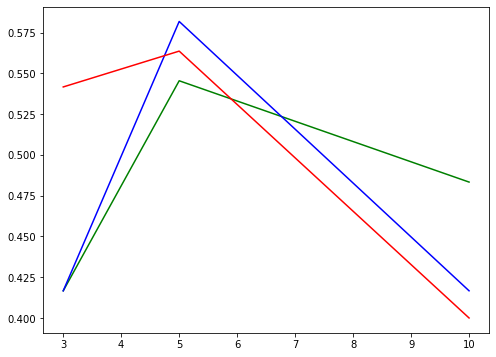

In [11]:
num_folds = [3,5,10]#commonly used k folds
acc_rf = []
acc_ada = []
acc_gb = []

for fold in num_folds:
    rf, ada, gb = sklearn_cross_validation(X_train_AAPL, y_train_AAPL, fold, verbose=True, plot=True)
    acc_rf.append(rf)
    acc_ada.append(ada)
    acc_gb.append(gb)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
ax.plot(num_folds, acc_rf, color = 'Green')
ax.plot(num_folds, acc_ada, color = 'Blue')
ax.plot(num_folds, acc_gb, color = 'Red')

Top 20 Best Features : 

High                     0.032461
volume_nvi               0.023989
Open                     0.023636
volume_vwap              0.021207
trend_vortex_ind_diff    0.020915
momentum_pvo             0.020386
momentum_stoch_rsi_k     0.020207
trend_dpo                0.019764
volume_vpt               0.019516
trend_adx_pos            0.019372
volume_adi               0.018485
volume_em                0.017996
Low                      0.017896
trend_mass_index         0.017721
momentum_pvo_hist        0.017166
trend_sma_fast           0.016392
momentum_stoch           0.015654
momentum_tsi             0.015560
volatility_kch           0.015187
trend_adx                0.014643
dtype: float64


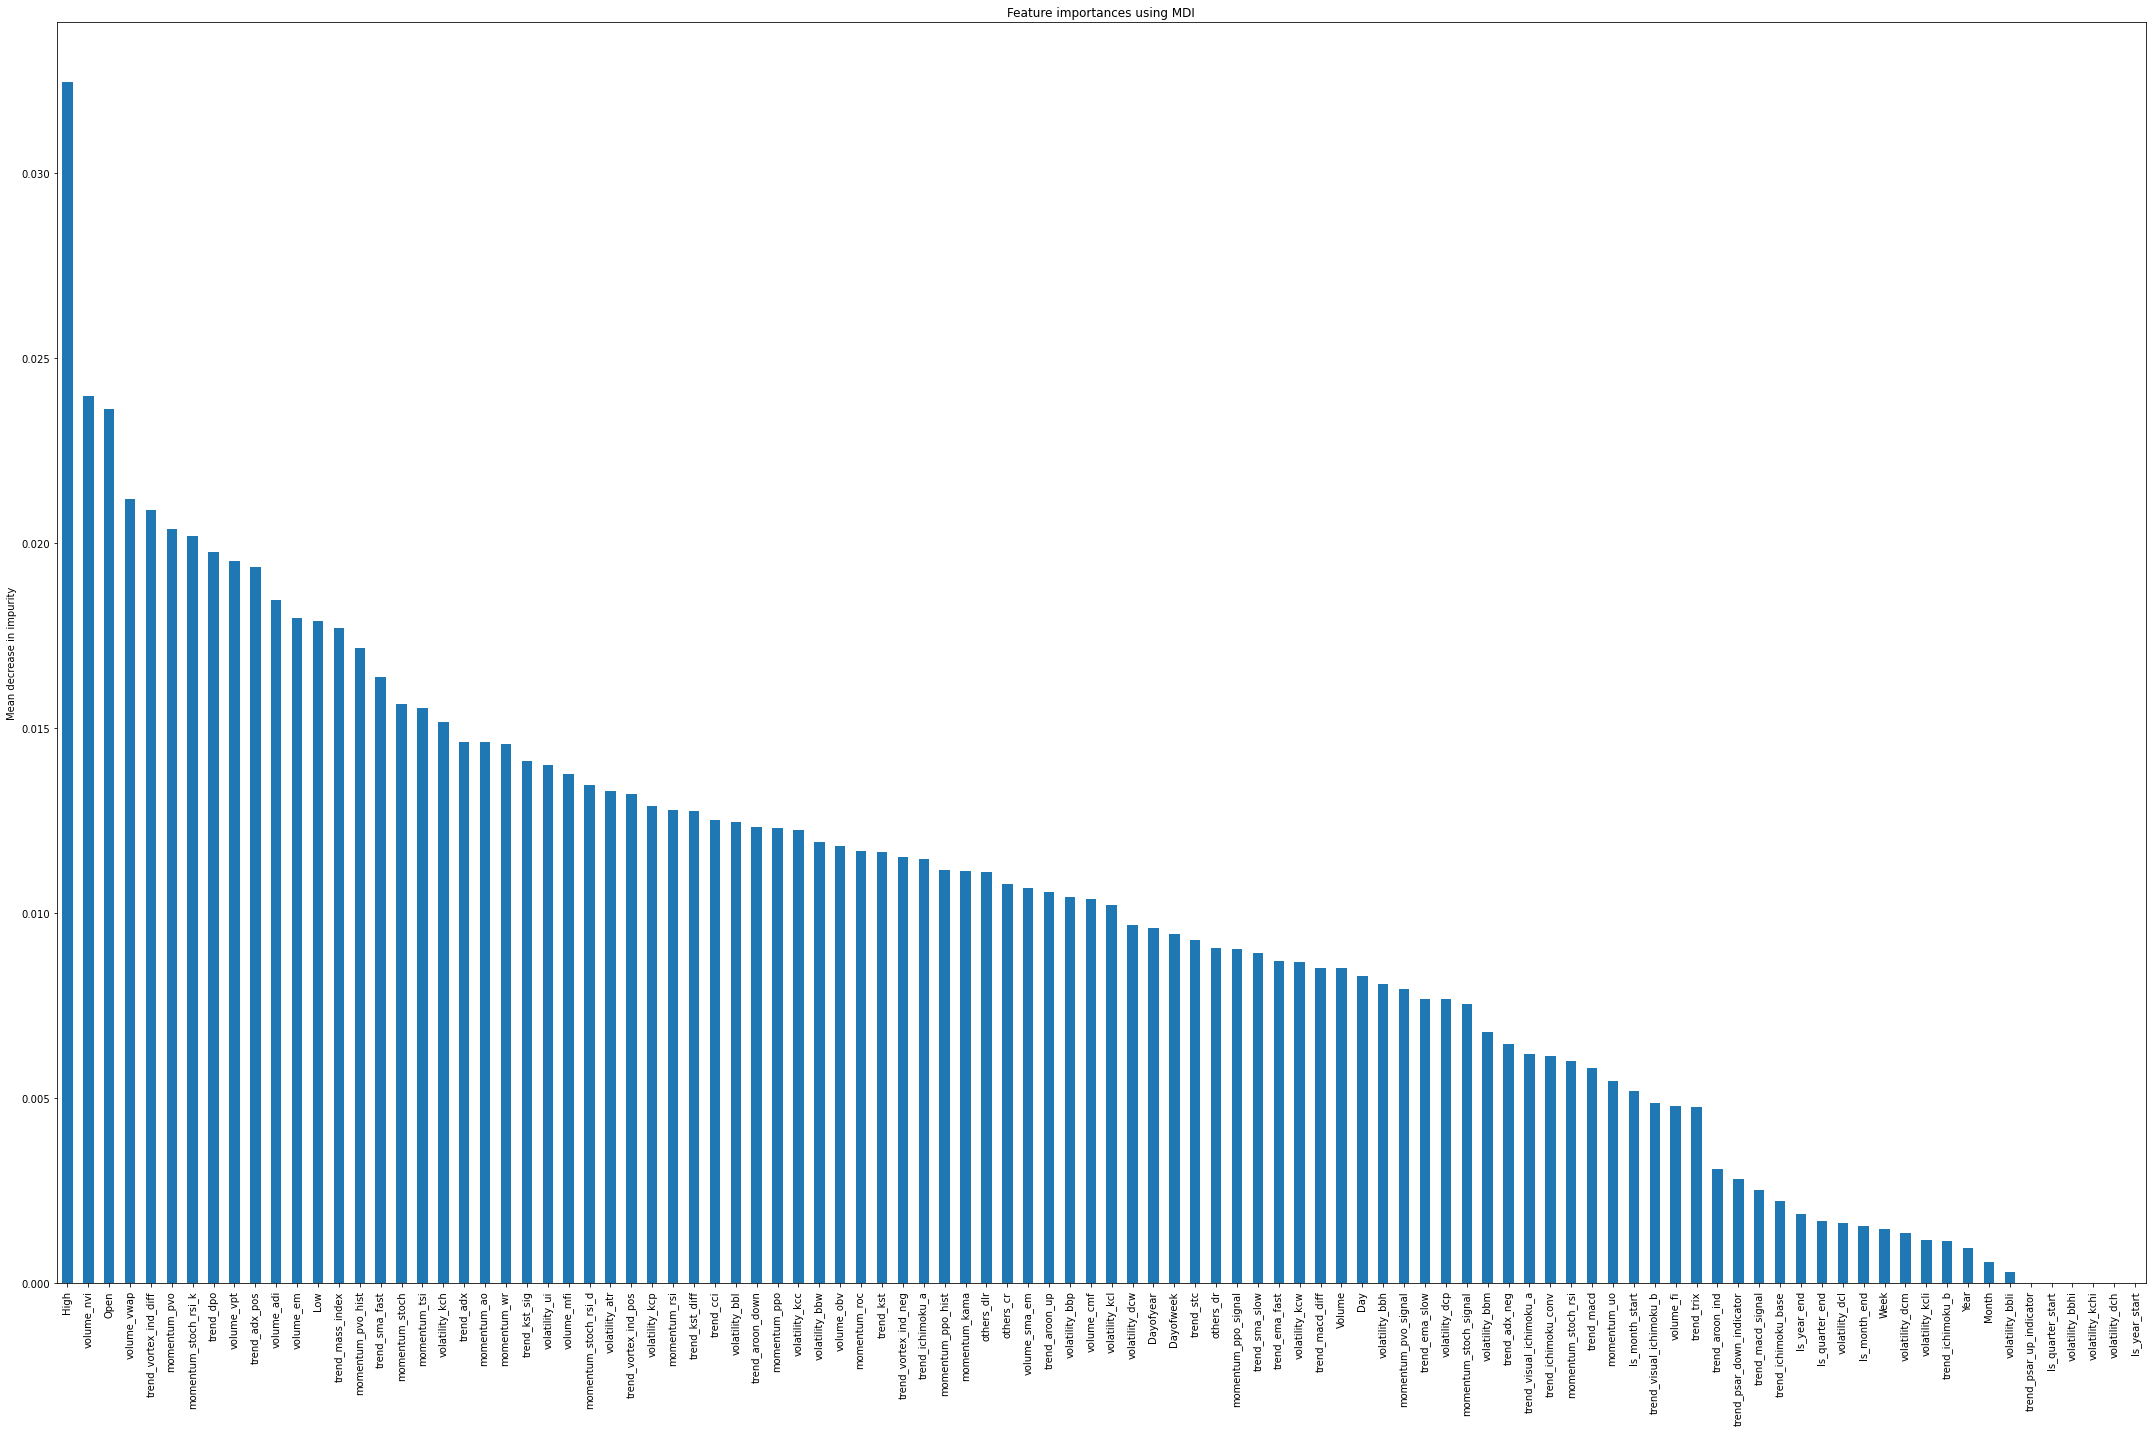

In [12]:
_ = feature_importance(rf_AAPL, columns_AAPL)

Top 20 Best Features : 

trend_dpo                0.078
momentum_pvo             0.044
volume_obv               0.042
momentum_stoch_rsi_d     0.040
trend_vortex_ind_diff    0.040
trend_mass_index         0.040
High                     0.034
trend_vortex_ind_pos     0.032
volume_vpt               0.032
trend_adx                0.030
trend_kst_diff           0.028
volatility_bbl           0.026
volatility_kcl           0.026
trend_aroon_down         0.024
volume_nvi               0.022
momentum_ao              0.022
momentum_pvo_signal      0.020
volume_cmf               0.018
Open                     0.018
trend_stc                0.018
dtype: float64


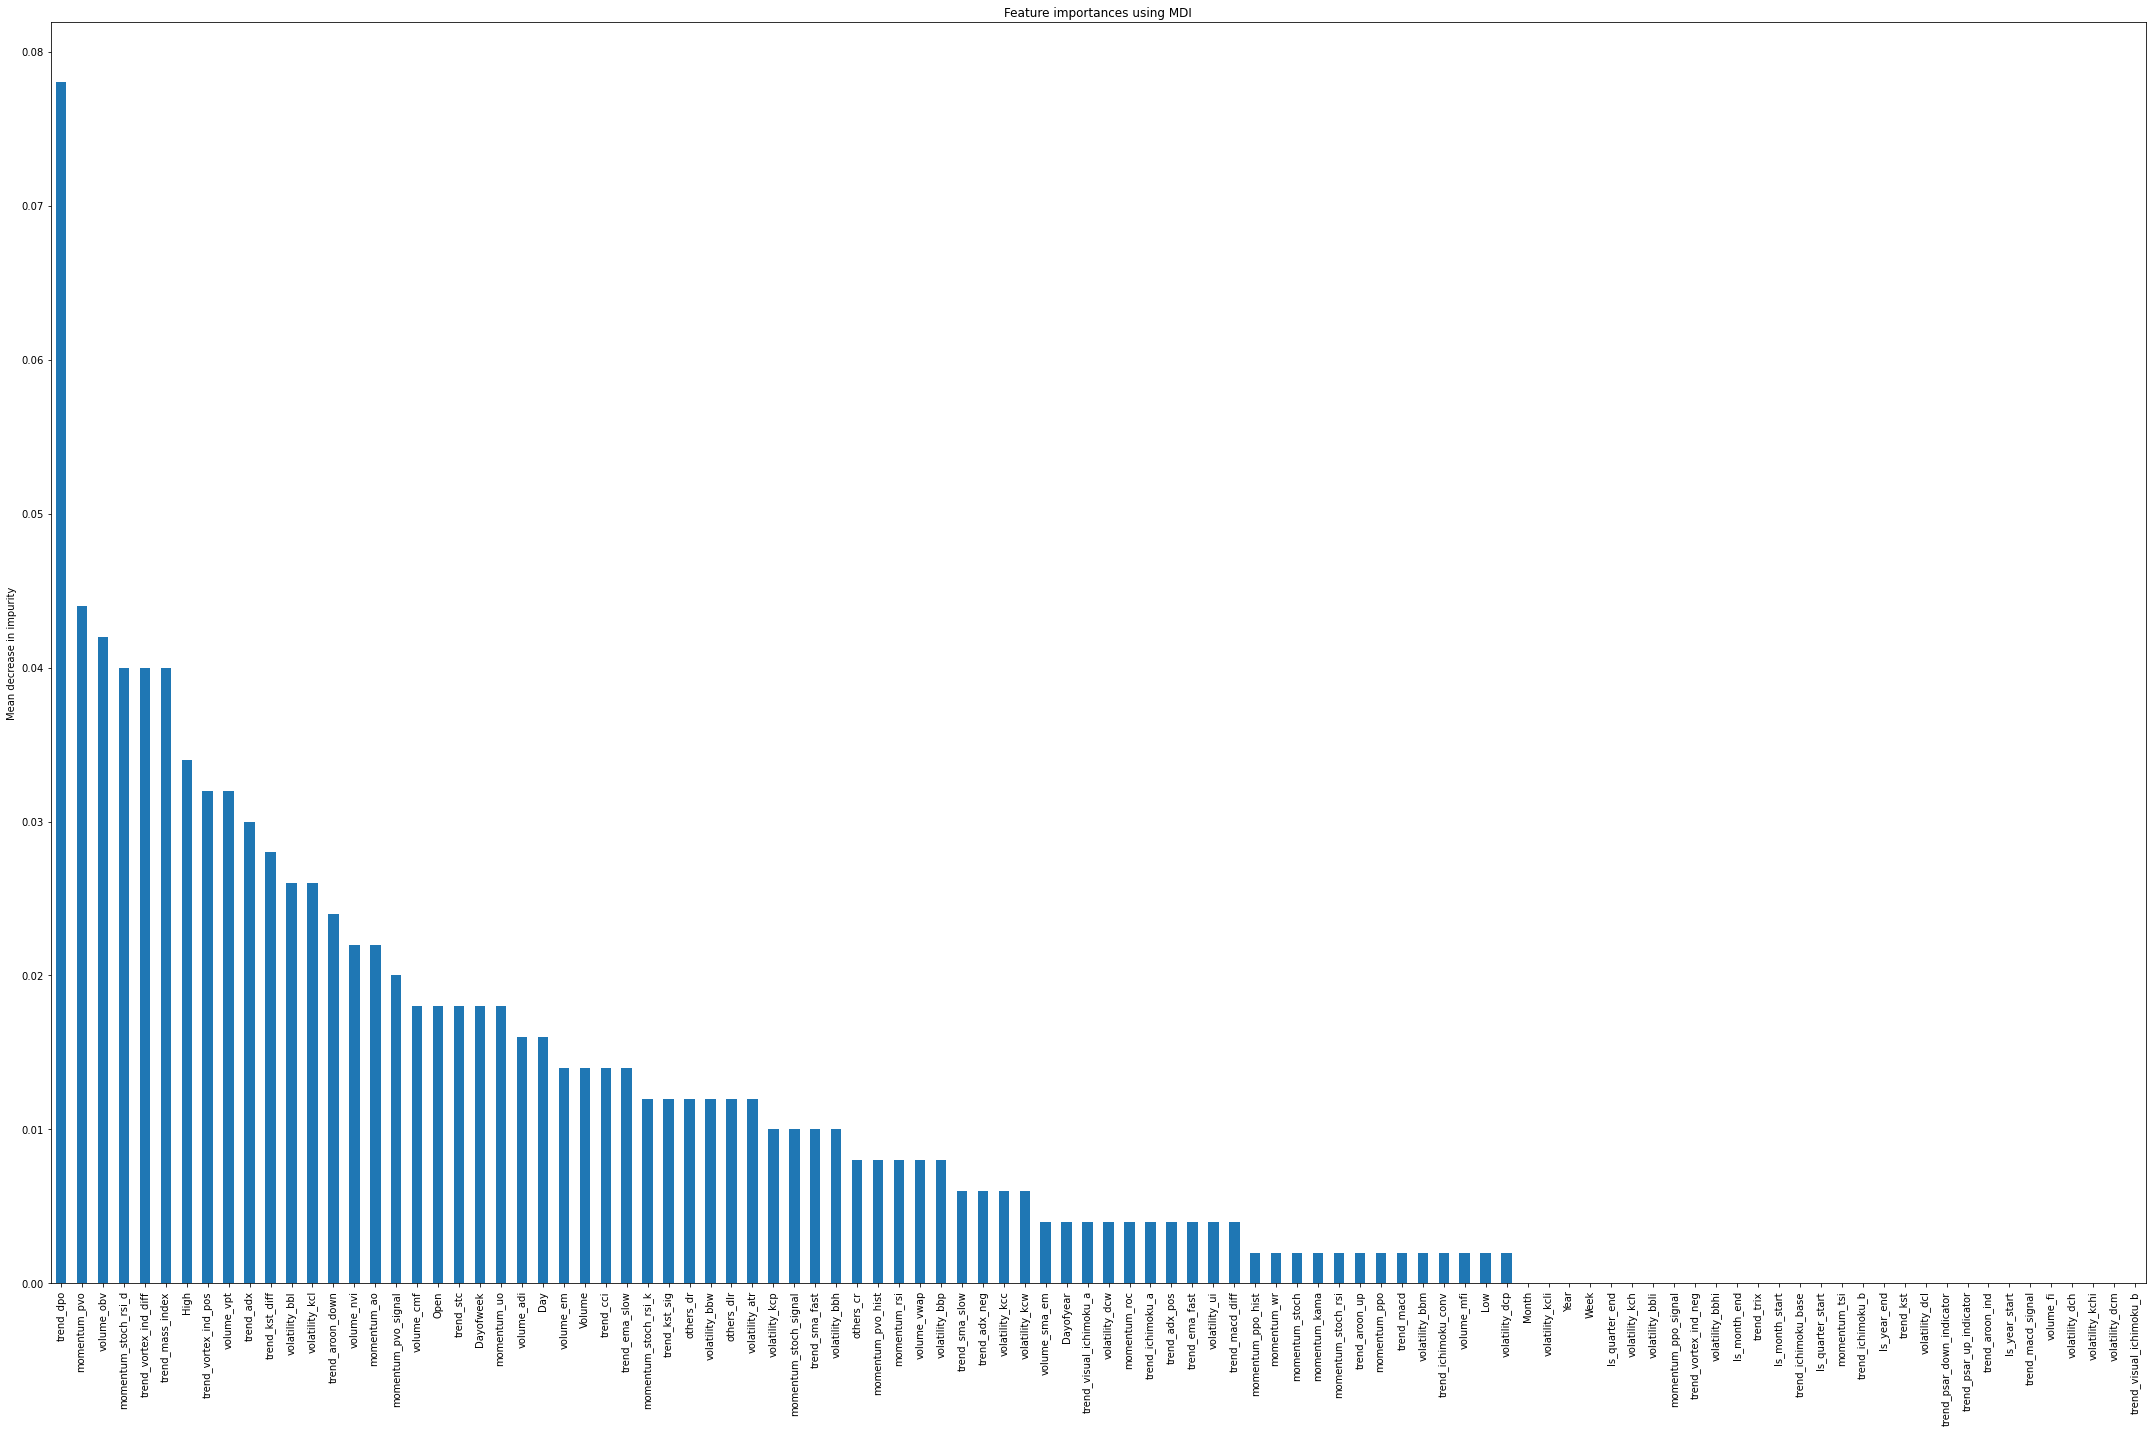

In [13]:
_ = feature_importance(ada_AAPL, columns_AAPL)

Top 20 Best Features : 

trend_dpo                0.077737
momentum_pvo             0.067055
volume_obv               0.053653
volume_nvi               0.050779
trend_kst_diff           0.042664
trend_stc                0.042240
volatility_ui            0.035068
trend_mass_index         0.034684
Open                     0.033381
trend_kst_sig            0.032080
trend_sma_fast           0.031691
momentum_stoch_signal    0.029415
trend_cci                0.029414
High                     0.025719
Dayofweek                0.022351
volume_vwap              0.021265
trend_vortex_ind_pos     0.016857
momentum_stoch_rsi_d     0.016789
volume_vpt               0.016517
momentum_pvo_hist        0.016449
dtype: float64


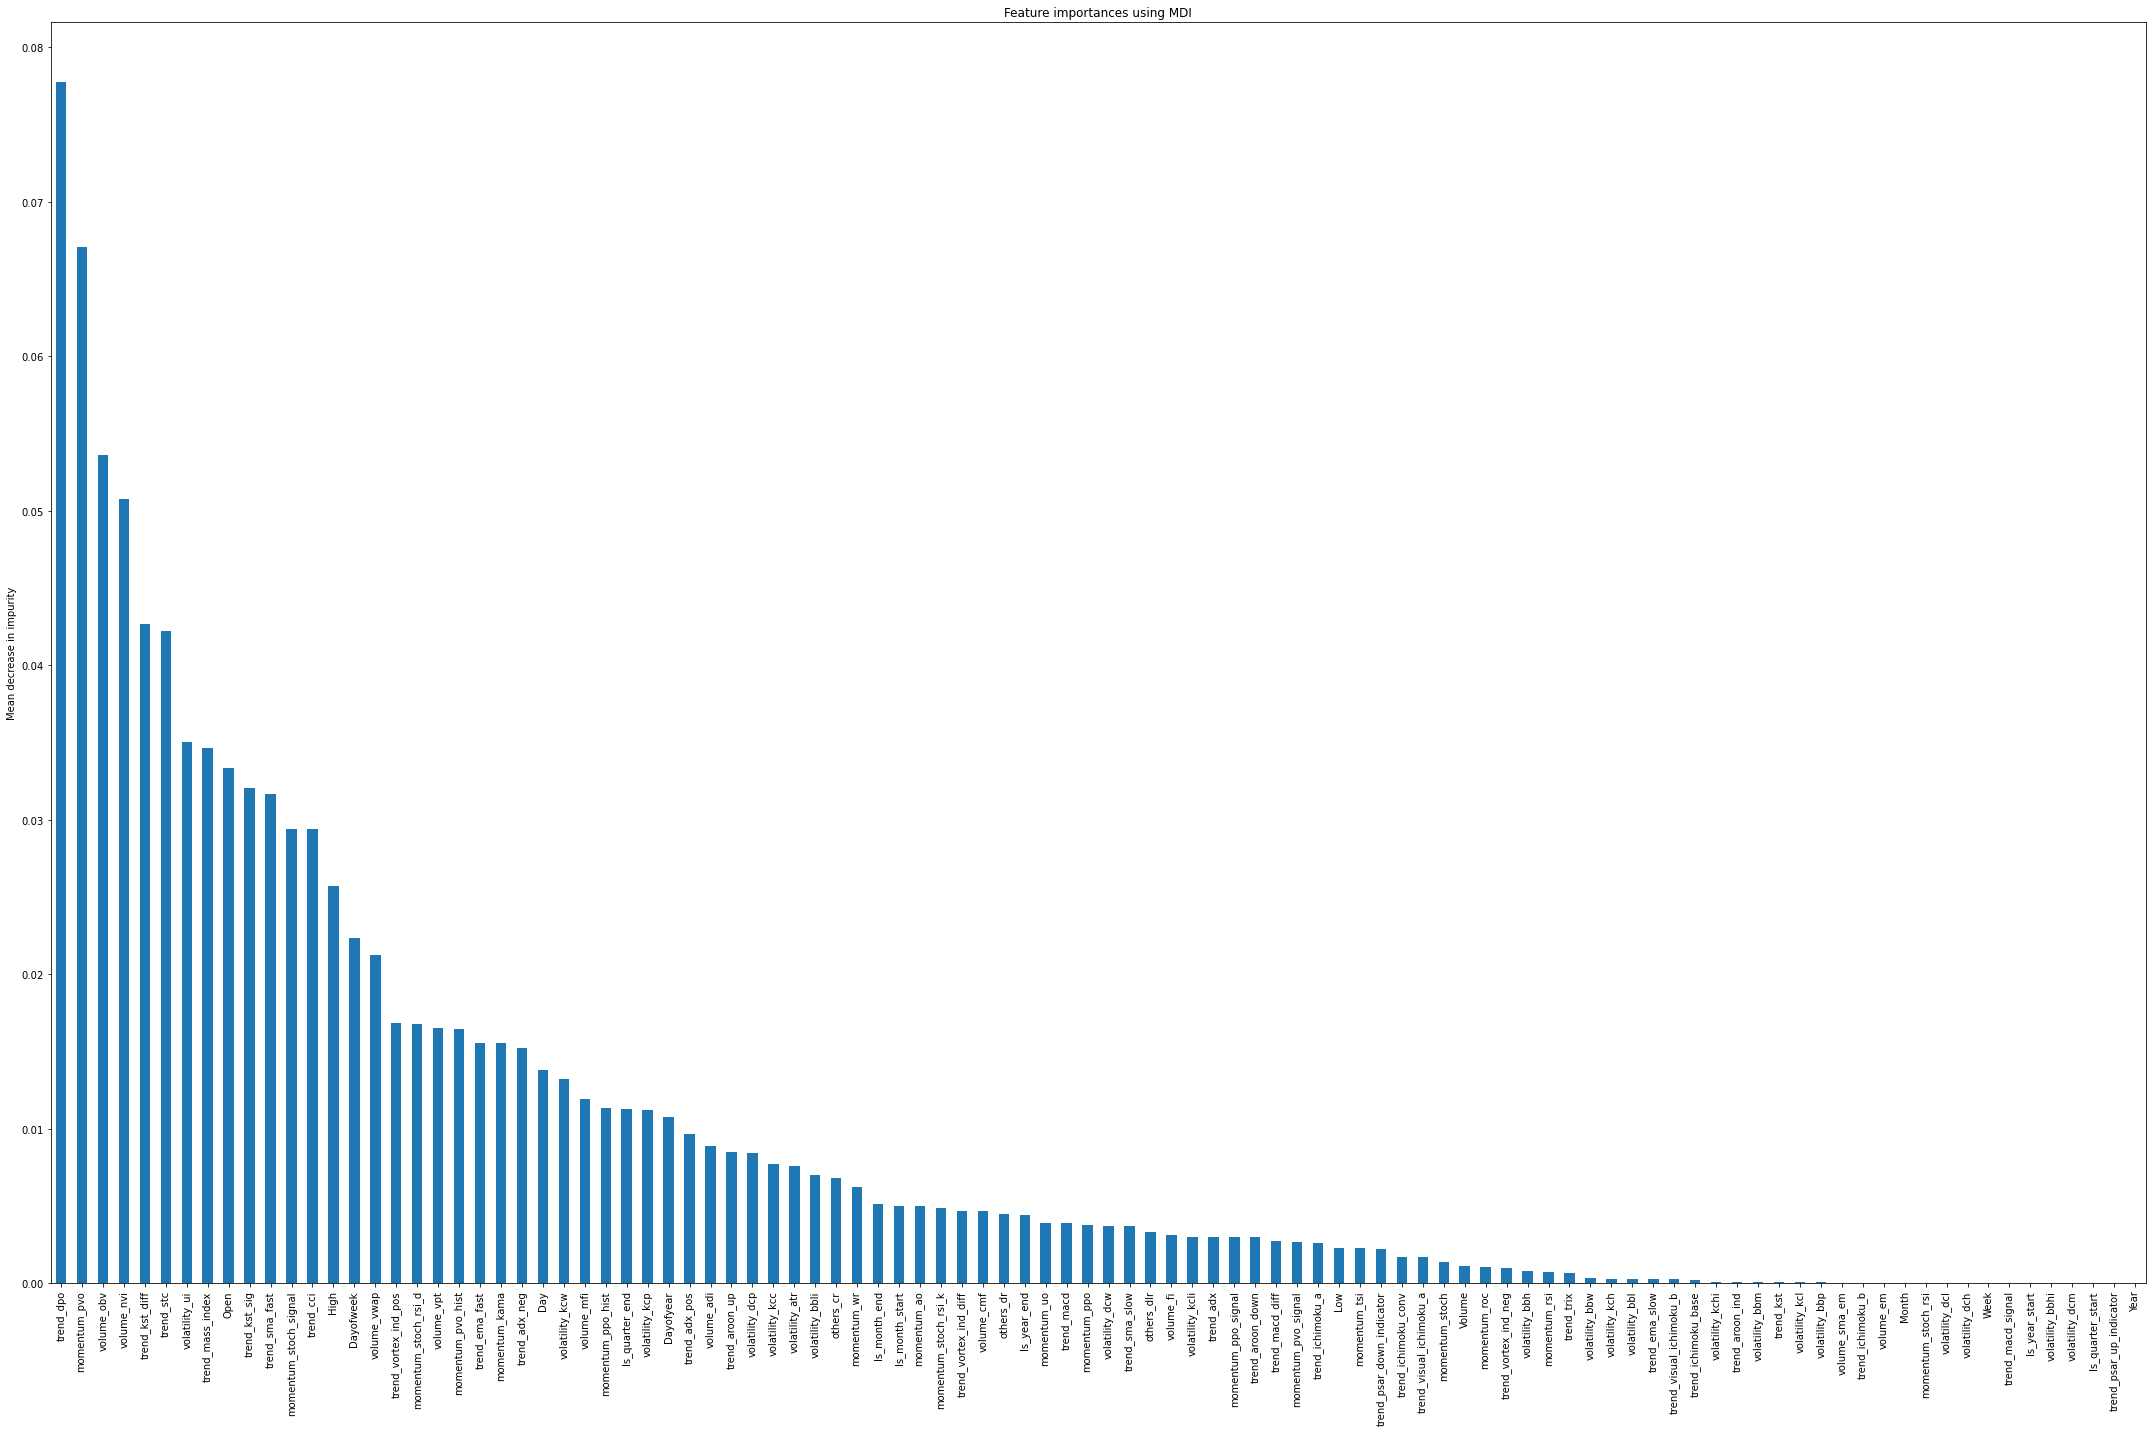

In [14]:
_ = feature_importance(gra_AAPL, columns_AAPL)

Top 20 Best Features : 

trend_dpo                0.058500
momentum_pvo             0.043814
volume_obv               0.035825
volume_nvi               0.032256
trend_mass_index         0.030802
High                     0.030726
trend_kst_diff           0.027807
Open                     0.025005
momentum_stoch_rsi_d     0.023420
trend_stc                0.023173
volume_vpt               0.022678
trend_vortex_ind_diff    0.021866
trend_vortex_ind_pos     0.020693
trend_kst_sig            0.019398
trend_sma_fast           0.019361
trend_cci                0.018644
volatility_ui            0.017695
volume_vwap              0.016824
Dayofweek                0.016600
trend_adx                0.015880
dtype: float64


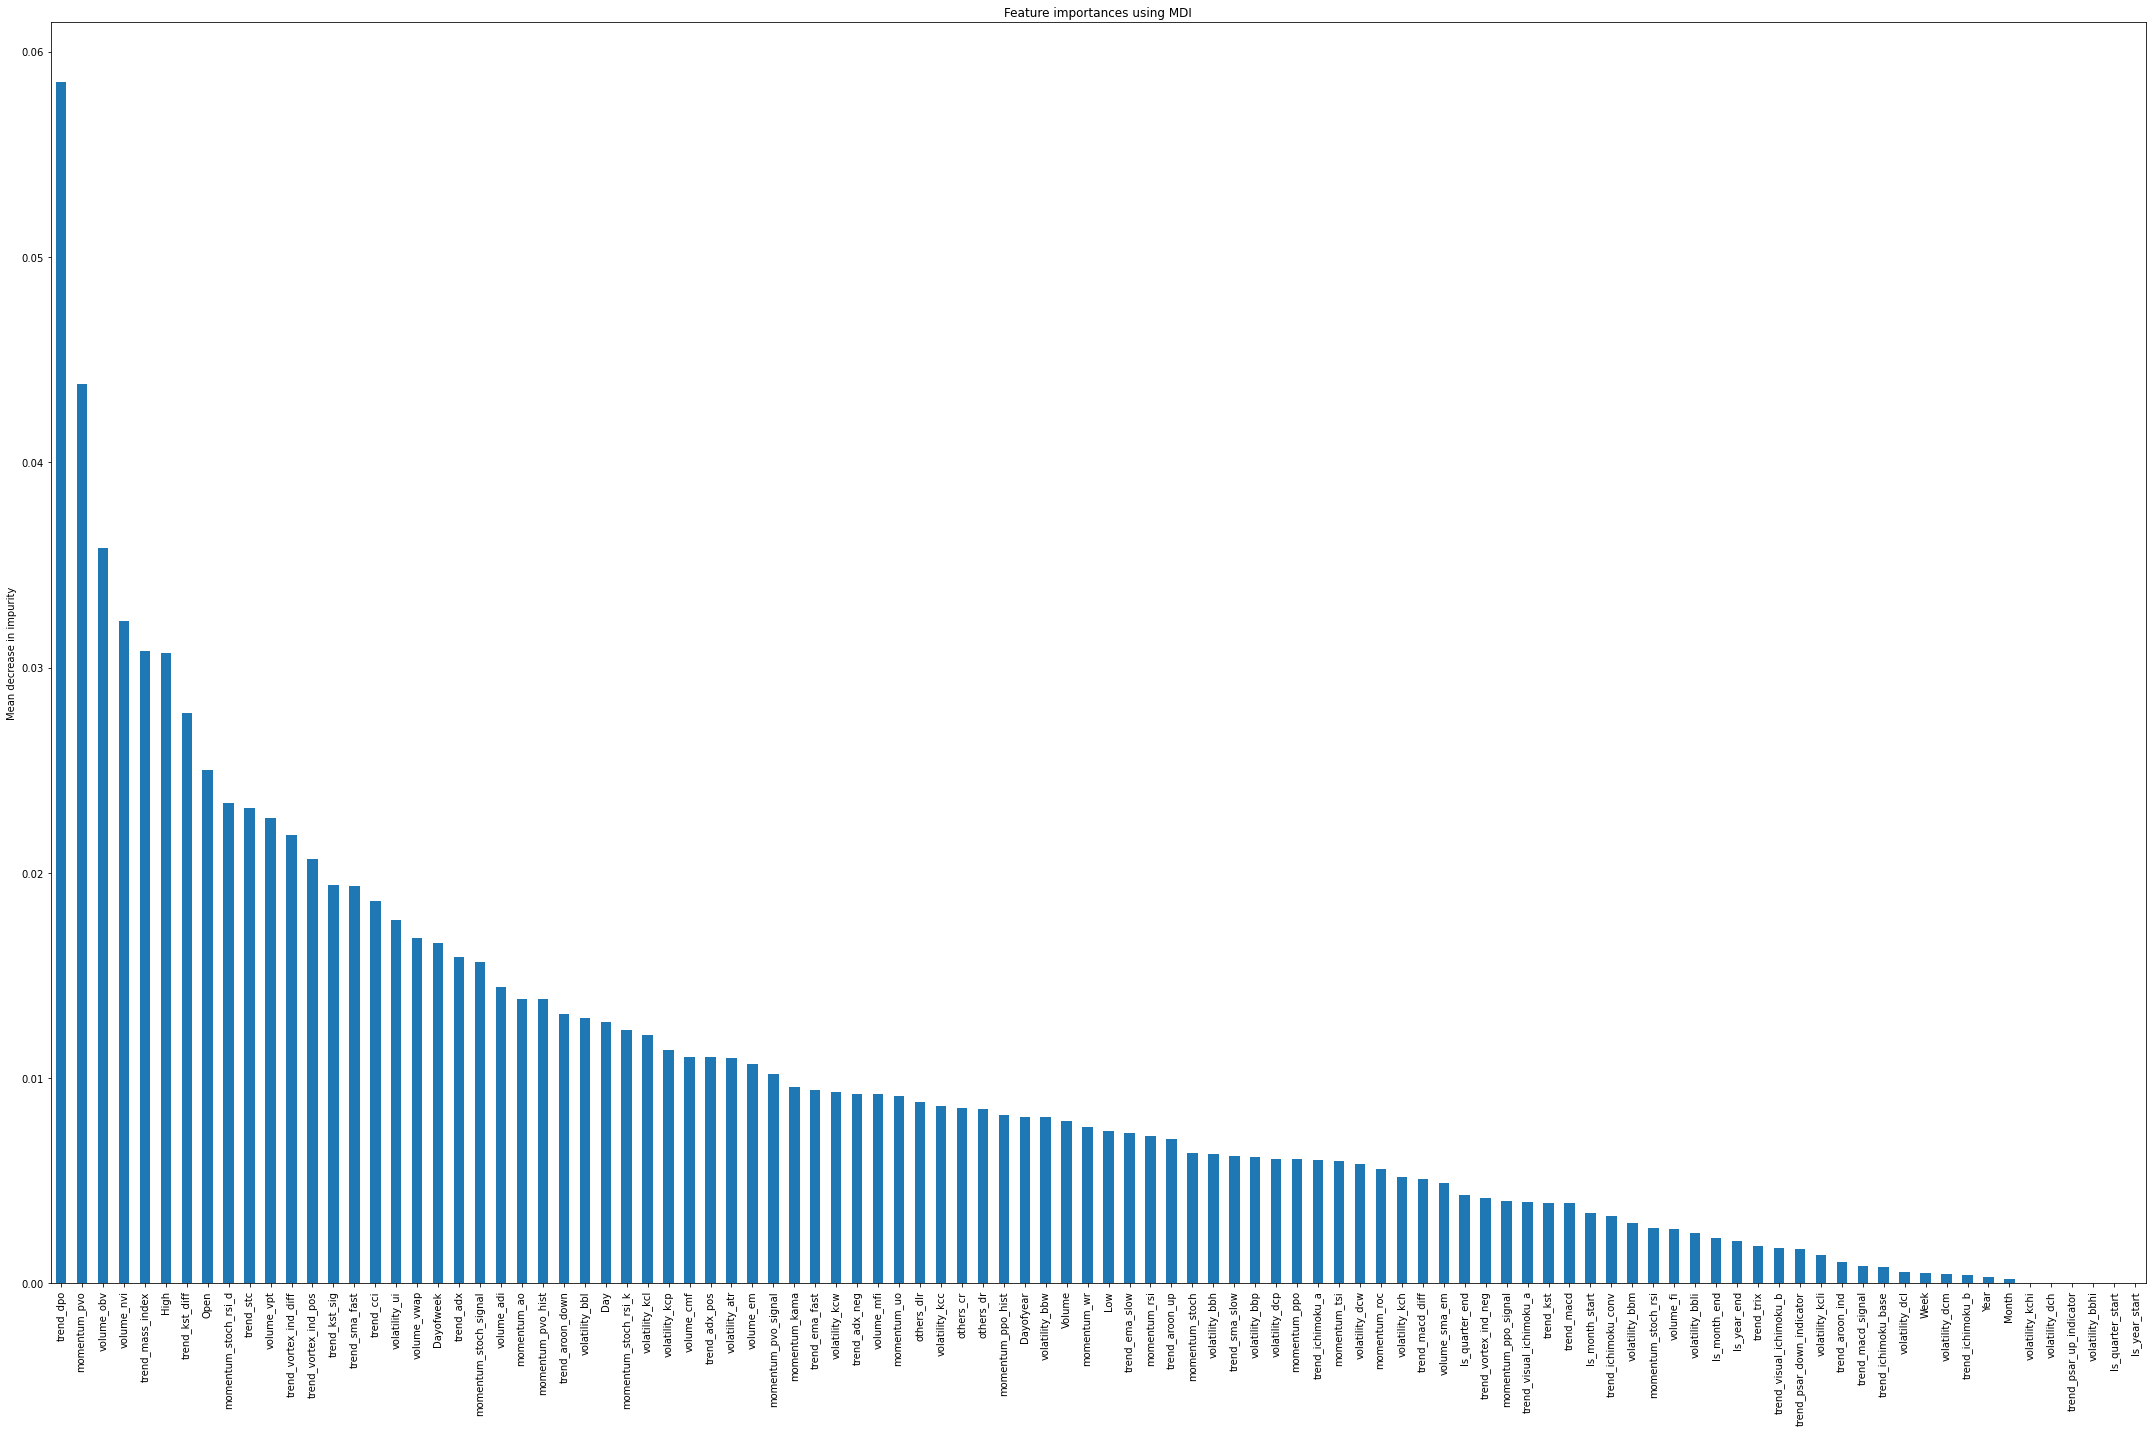

In [15]:
ave_AAPL = (rf_AAPL + ada_AAPL + gra_AAPL) / 3
imp_AAPL = feature_importance(ave_AAPL, columns_AAPL)

## Microsoft

In [16]:
# MSFT : Data with full set of technical features
X_train_MSFT, y_train_MSFT, columns_MSFT = prepare_dataset('data/MSFT_data.csv')

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [17]:
rf_MSFT, ada_MSFT, gra_MSFT = sklearn_cross_validation(X_train_MSFT, y_train_MSFT, 5, verbose=True, plot=False)

Mean Accuracy of Random Forests 0.4545454545454546
Mean Accuracy of Adaboost 0.509090909090909
Mean Accuracy of Gradient Boosting 0.38181818181818183


Top 20 Best Features : 

others_cr               0.100383
momentum_ppo_hist       0.063520
volume_adi              0.038763
volume_nvi              0.037789
Low                     0.030527
High                    0.029863
trend_adx_pos           0.028870
volatility_bbl          0.028620
trend_macd_signal       0.026302
trend_vortex_ind_pos    0.025335
momentum_pvo_hist       0.025104
volatility_kcp          0.023054
trend_adx_neg           0.022281
trend_cci               0.021912
trend_macd_diff         0.020929
Open                    0.018663
momentum_roc            0.017961
momentum_rsi            0.017757
volume_em               0.015169
momentum_wr             0.014672
dtype: float64


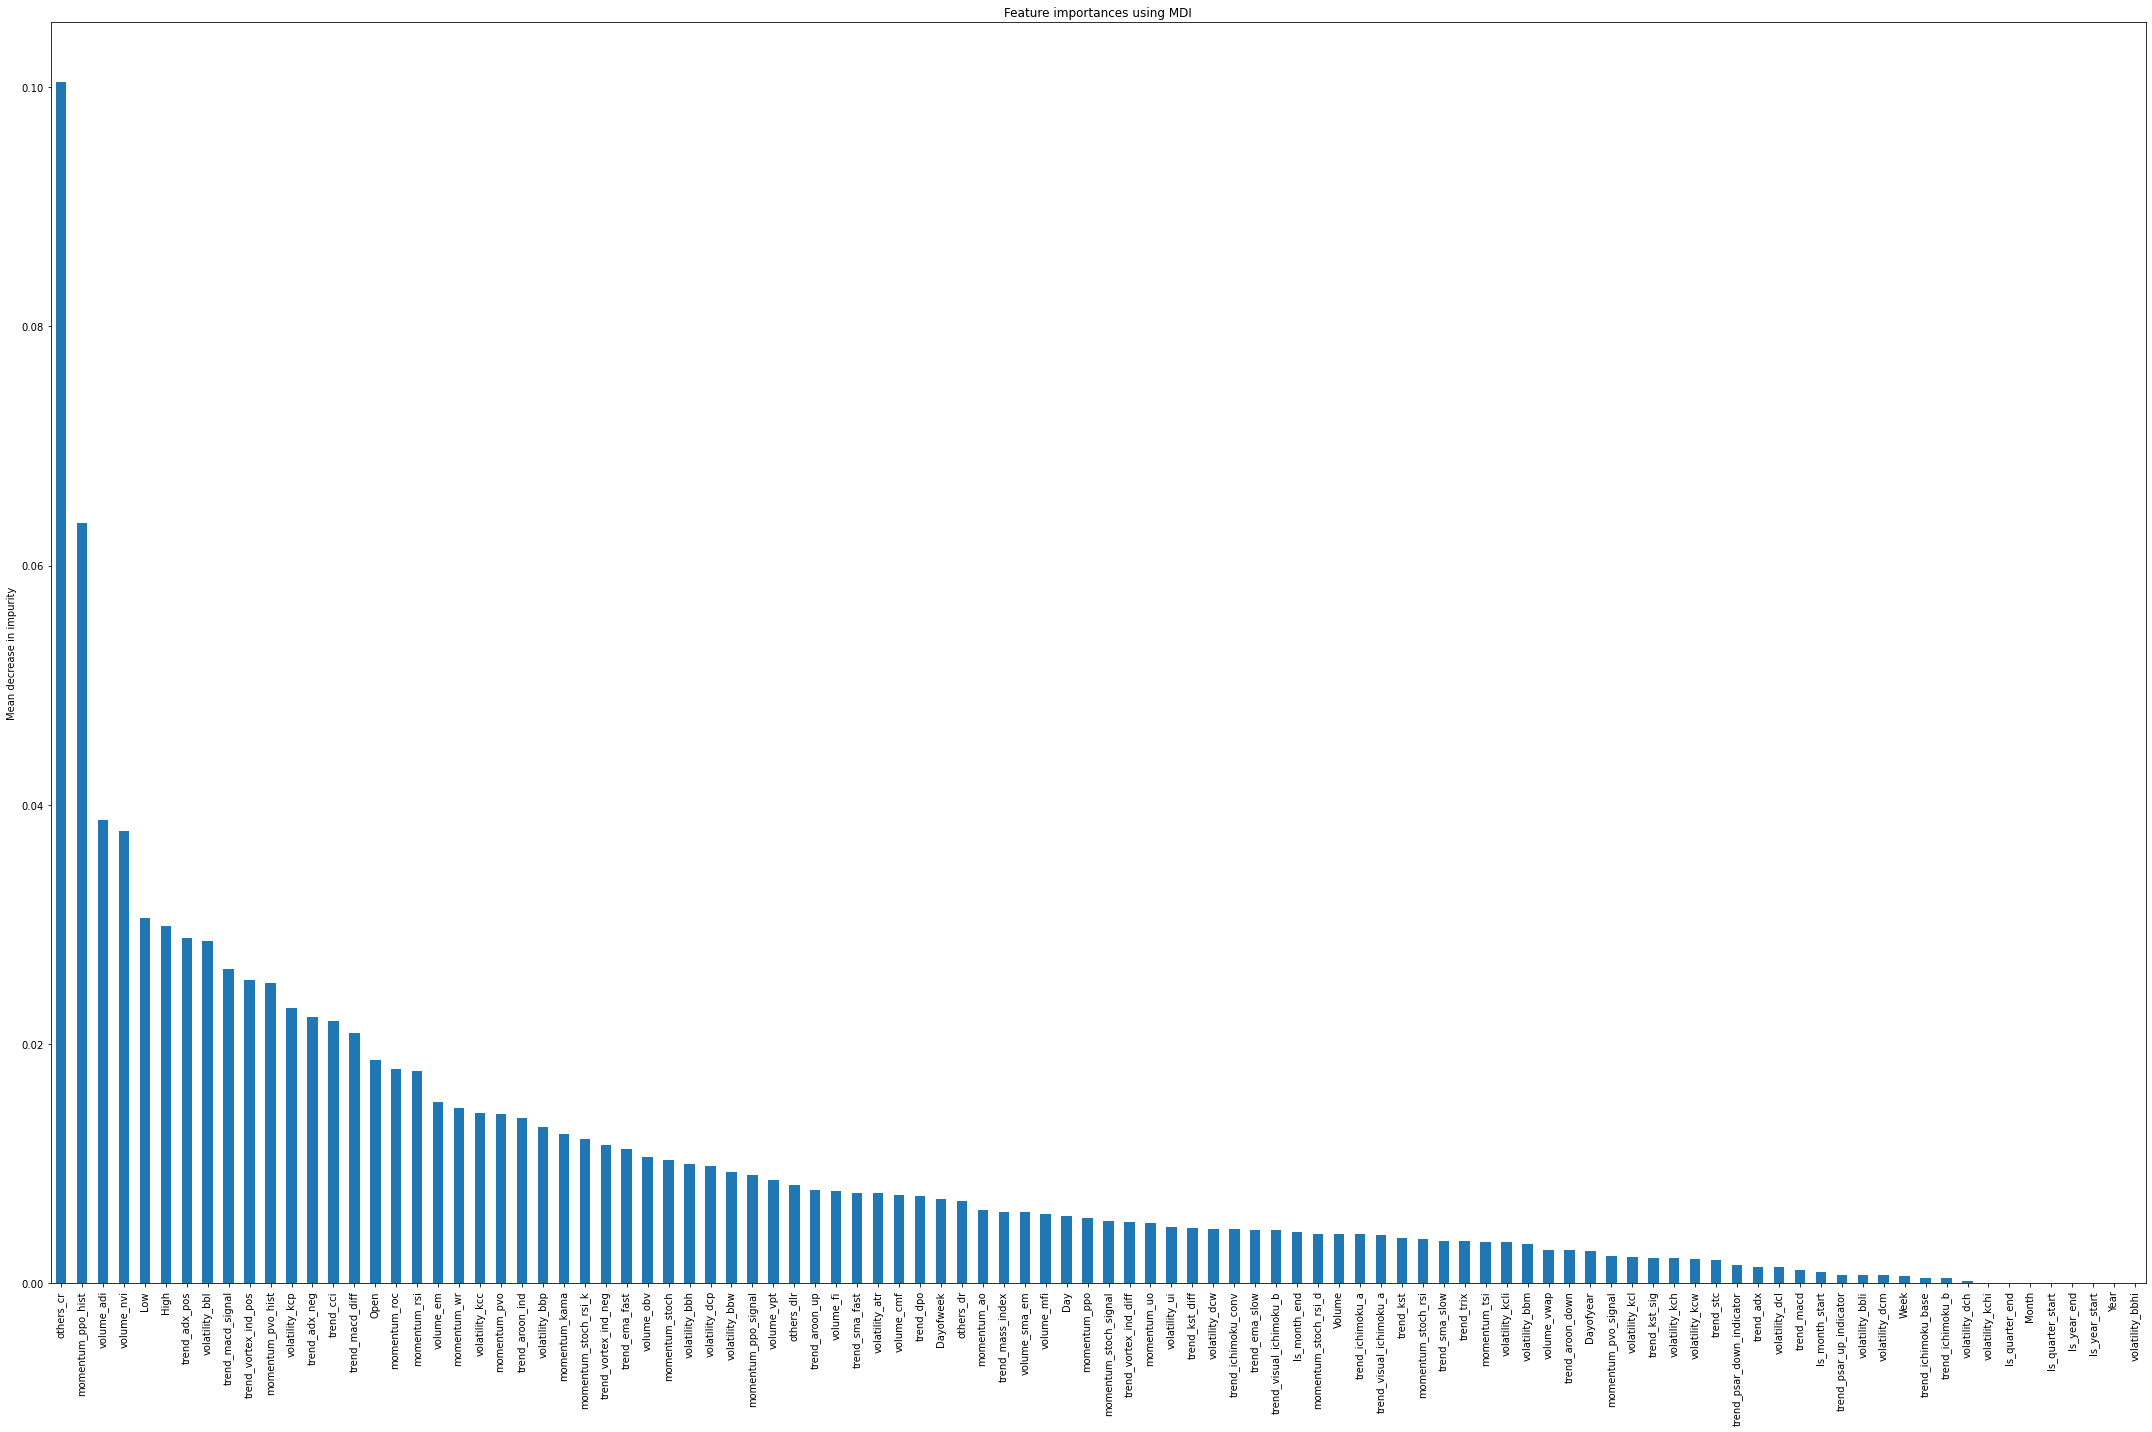

In [18]:
ave_MSFT = (rf_MSFT + ada_MSFT + gra_MSFT) / 3
imp_MSFT = feature_importance(ave_MSFT, columns_MSFT)

## NVDIA

In [19]:
# NVDA : Data with full set of technical features
X_train_NVDA, y_train_NVDA, columns_NVDA = prepare_dataset('data/NVDA_data.csv')

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


In [20]:
rf_NVDA, ada_NVDA, gra_NVDA = sklearn_cross_validation(X_train_NVDA, y_train_NVDA, 5, verbose=True, plot=False)

Mean Accuracy of Random Forests 0.4909090909090909
Mean Accuracy of Adaboost 0.47272727272727266
Mean Accuracy of Gradient Boosting 0.47272727272727266


Top 20 Best Features : 

trend_aroon_ind         0.080592
others_dlr              0.059691
others_cr               0.058115
others_dr               0.052714
momentum_rsi            0.044429
volatility_atr          0.033473
trend_aroon_up          0.028575
momentum_pvo_hist       0.027485
volume_adi              0.023658
trend_vortex_ind_neg    0.020517
Volume                  0.018912
volume_obv              0.018809
volume_vpt              0.018078
Day                     0.016415
Dayofyear               0.016188
trend_dpo               0.015416
momentum_pvo            0.015356
Dayofweek               0.013730
volatility_kcw          0.013717
Is_quarter_end          0.012425
dtype: float64


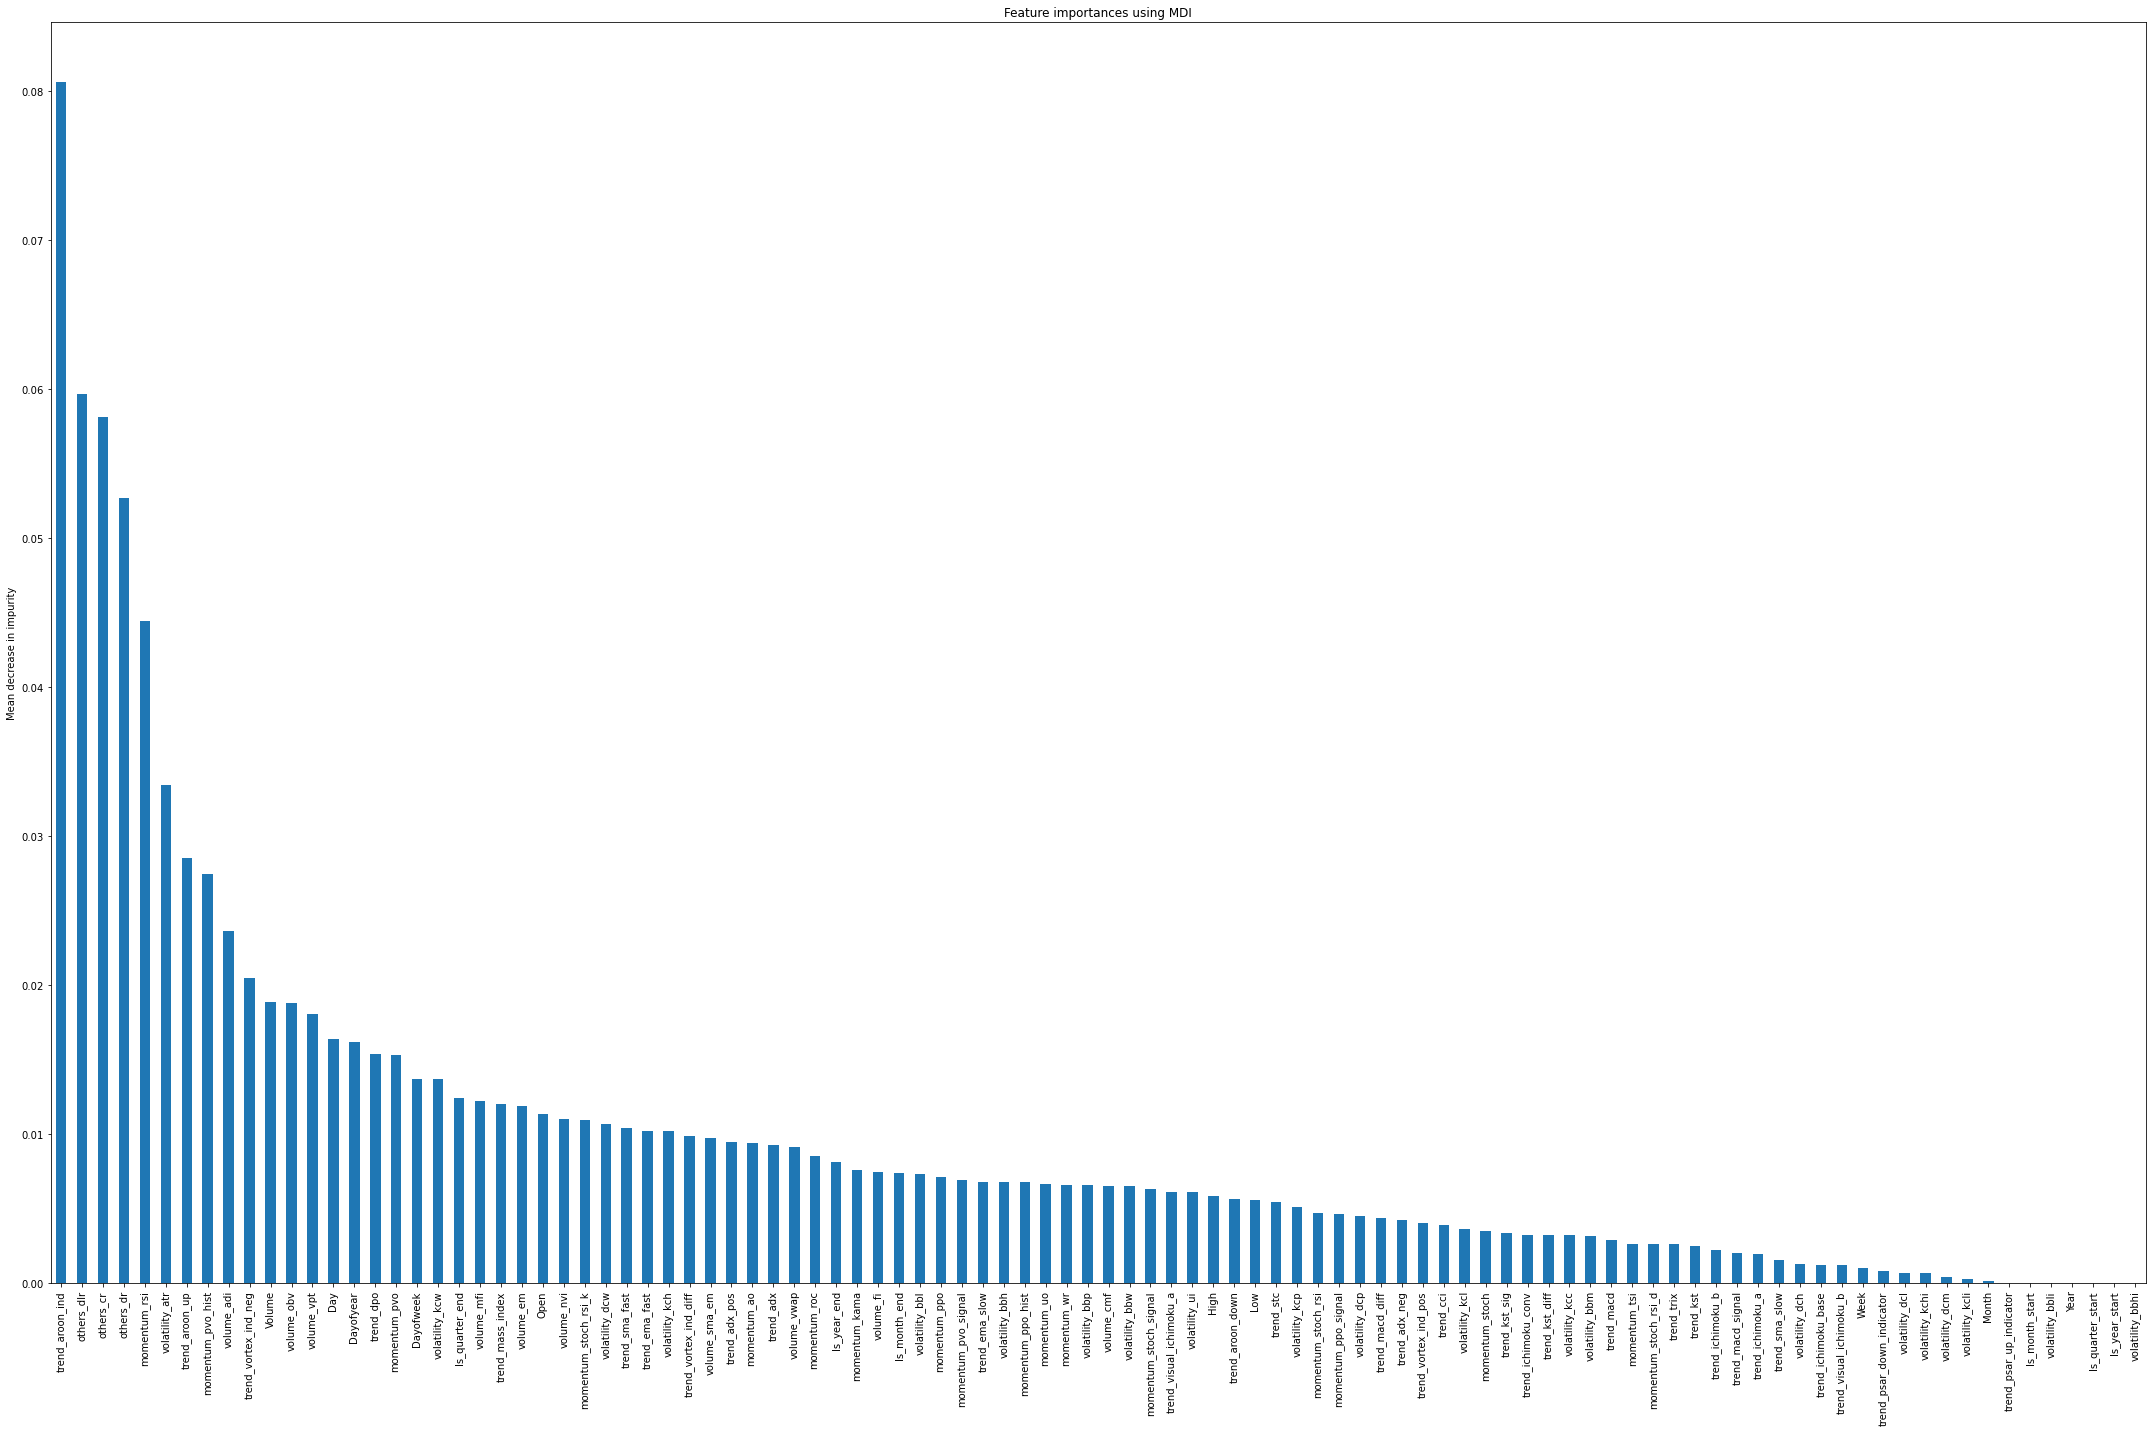

In [21]:
ave_NVDA = (rf_NVDA + ada_NVDA + gra_NVDA) / 3
imp_NVDA = feature_importance(ave_NVDA, columns_NVDA)

## Compare 3 companies feature importance

In [22]:
imp_AAPL.name = "AAPL"
imp_MSFT.name = "MSFT"
imp_NVDA.name = "NVDA"

all_companies = pd.merge(imp_AAPL, imp_MSFT, left_index=True, right_index=True)
all_companies = pd.merge(all_companies, imp_NVDA, left_index=True, right_index=True)

In [23]:
all_companies

,AAPL,MSFT,NVDA
trend_dpo,0.058500,0.007310,0.015416
momentum_pvo,0.043814,0.014194,0.015356
volume_obv,0.035825,0.010572,0.018809
volume_nvi,0.032256,0.037789,0.011029
trend_mass_index,0.030802,0.005955,0.012058
...,...,...,...
volatility_dch,0.000001,0.000170,0.001299
trend_psar_up_indicator,0.000000,0.000743,0.000050
volatility_bbhi,0.000000,0.000000,0.000000
Is_quarter_start,0.000000,0.000000,0.000000


<AxesSubplot:>

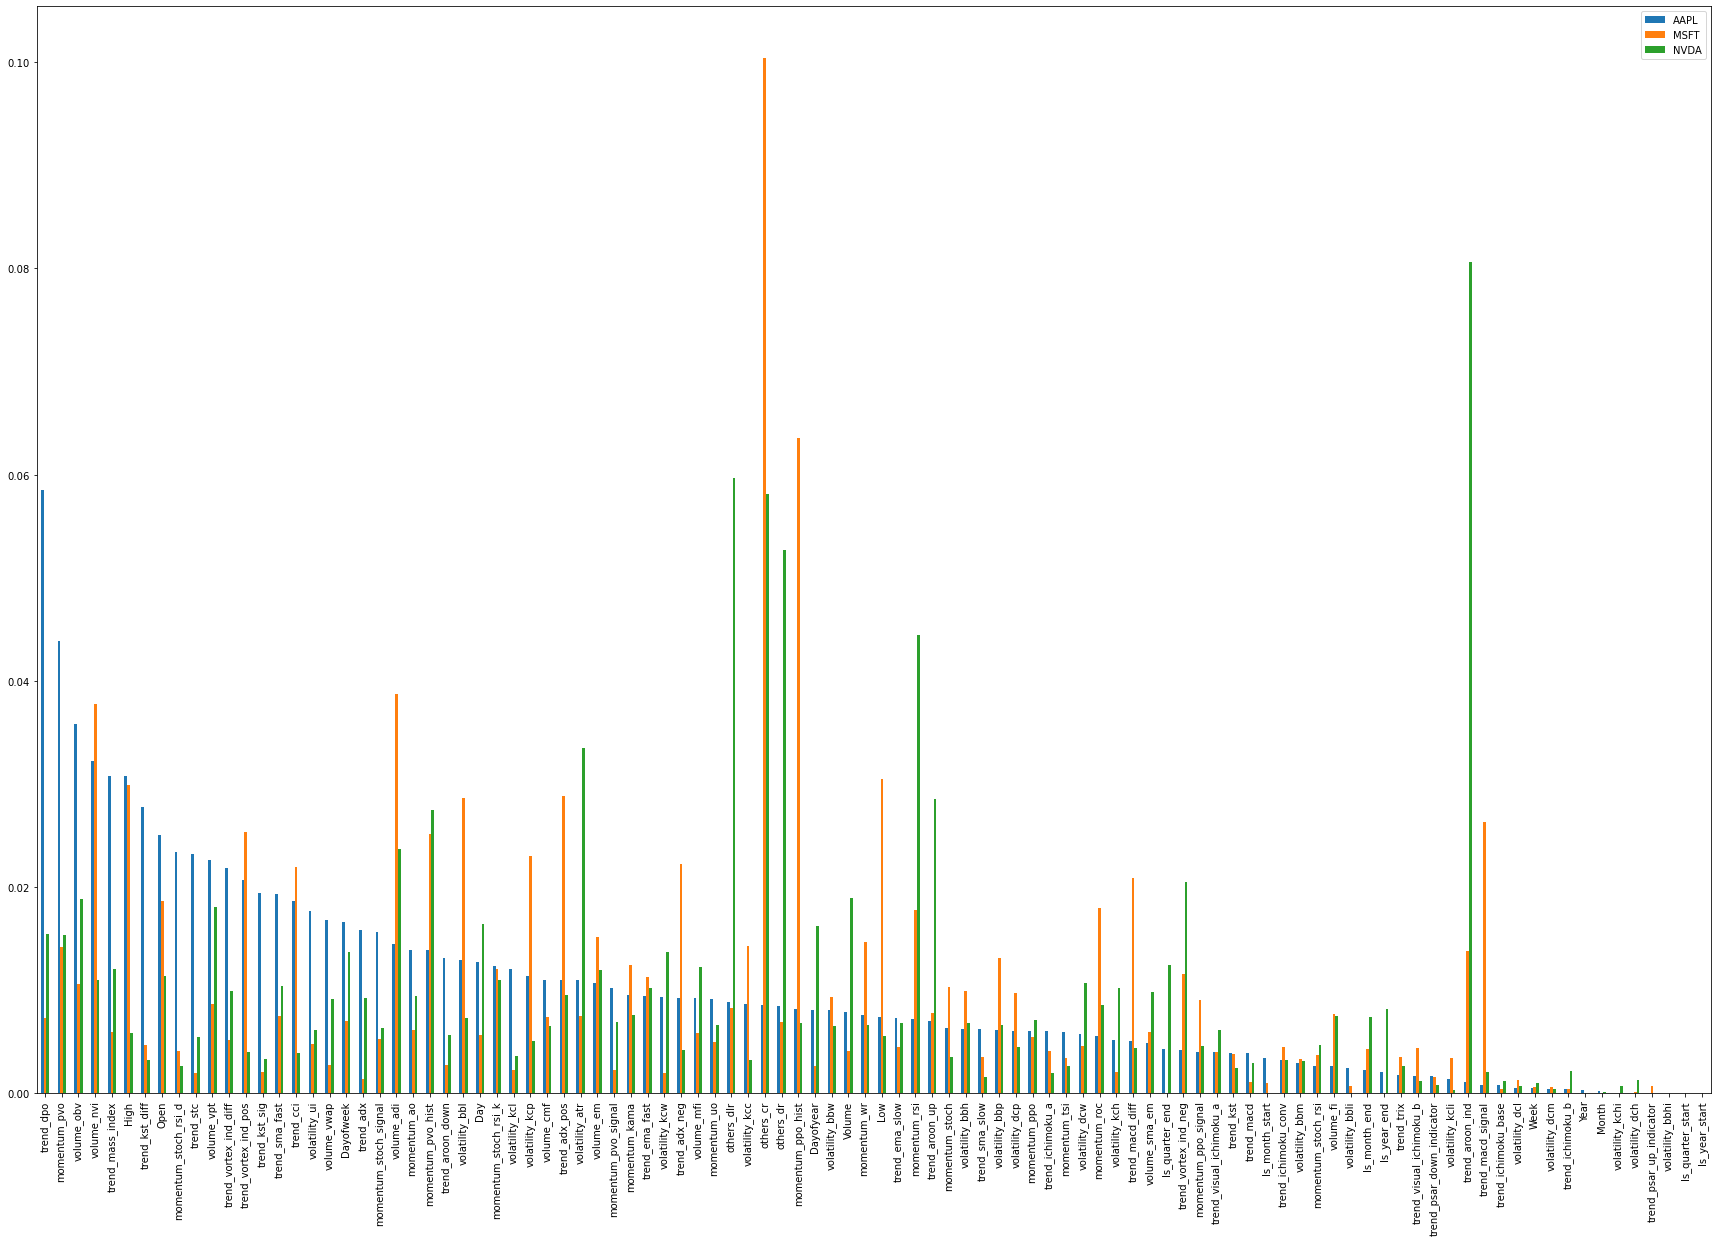

In [24]:
all_companies.plot(y=["AAPL", "MSFT", "NVDA"], kind="bar", figsize=(30,20), legend=True)

## Add Apple RoBERTa

In [25]:
# AAPL : Data with full set of technical features + sentiment score
X_train_AAPLs, y_train_AAPLs, columns_AAPLs = prepare_dataset(sentiment=True)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


Mean Accuracy of Random Forests 0.6799999999999999
Mean Accuracy of Adaboost 0.52
Mean Accuracy of Gradient Boosting 0.6
Top 20 Best Features : 

Volume                   0.121121
trend_ema_slow           0.084621
others_dlr               0.066765
others_dr                0.061949
trend_dpo                0.044181
volatility_bbh           0.037644
bearish                  0.026245
volatility_bbp           0.025441
volume_adi               0.025187
volume_fi                0.022341
momentum_stoch_signal    0.019333
trend_adx                0.014885
momentum_kama            0.013967
volatility_dcw           0.013709
volume_em                0.013179
trend_cci                0.012608
trend_aroon_down         0.012199
momentum_uo              0.011988
volatility_kcp           0.011868
volume_vpt               0.011114
dtype: float64


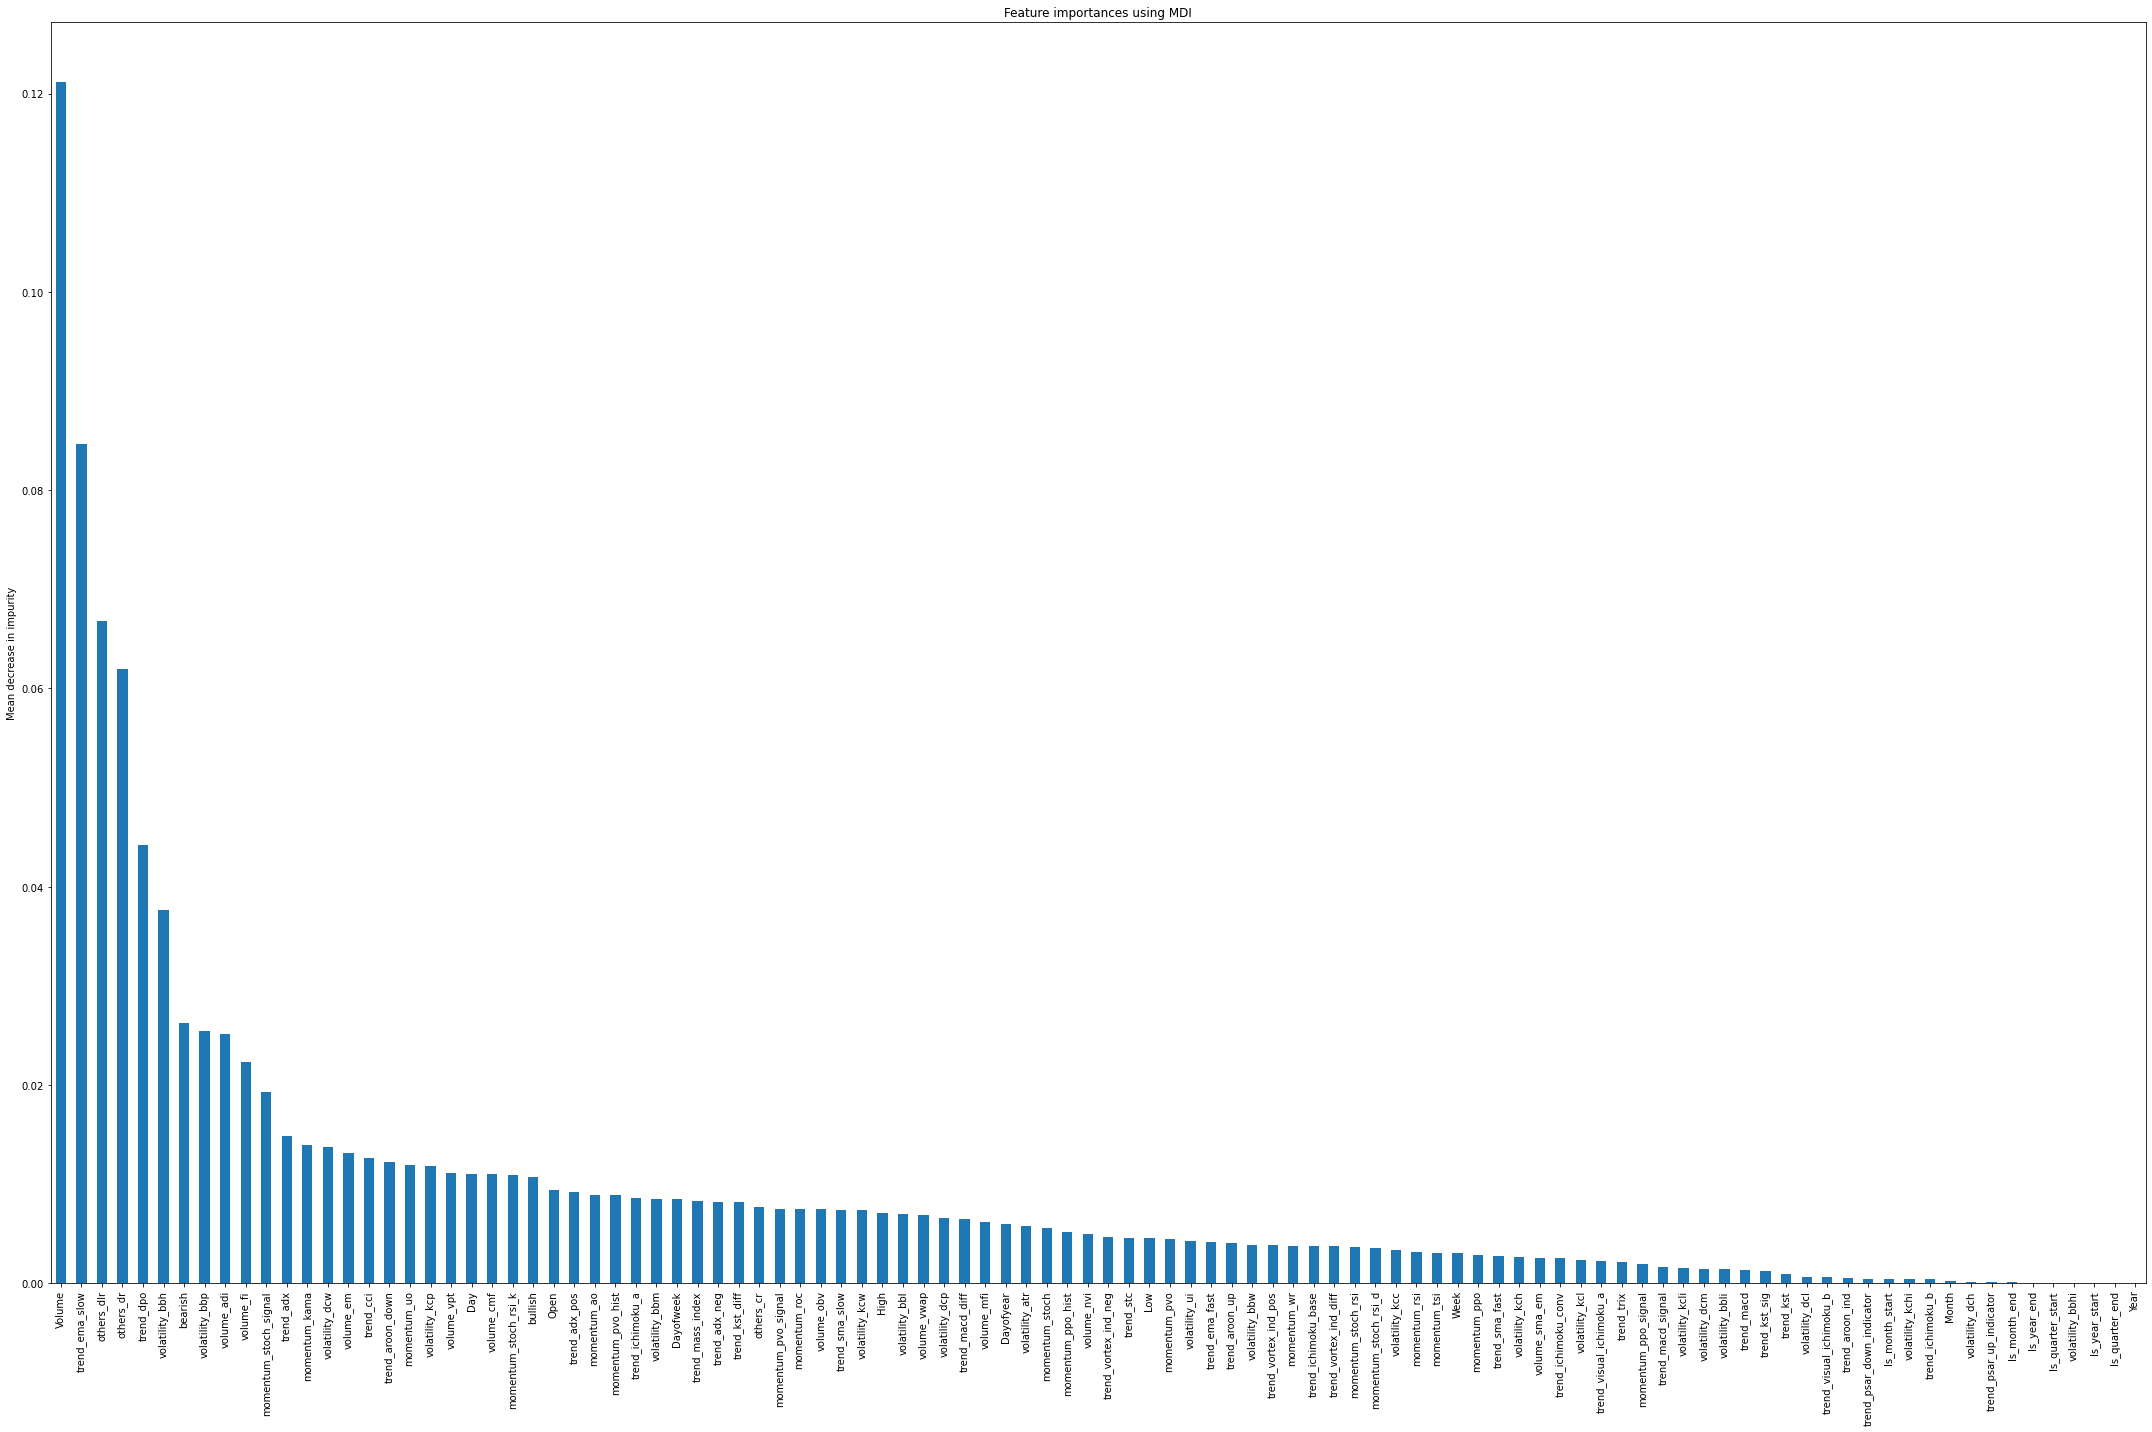

In [26]:
rf_AAPLs, ada_AAPLs, gra_AAPLs = sklearn_cross_validation(X_train_AAPLs, y_train_AAPLs, 5, verbose=True, plot=False)
ave_AAPLs = (rf_AAPLs + ada_AAPLs + gra_AAPLs) / 3
imp_AAPLs = feature_importance(ave_AAPLs, columns_AAPLs)

## Add Microsoft RoBERTa

In [27]:
# MSFT : Data with full set of technical features + sentiment score
X_train_MSFTs, y_train_MSFTs, columns_MSFTs = prepare_dataset(path = 'data/MSFT_data.csv', s_path = 'data/MSFT_byday_RoBERTa.csv', sentiment=True)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


Mean Accuracy of Random Forests 0.58
Mean Accuracy of Adaboost 0.6
Mean Accuracy of Gradient Boosting 0.6
Top 20 Best Features : 

trend_cci               0.085730
trend_dpo               0.054026
others_cr               0.046767
trend_adx_neg           0.044980
others_dlr              0.039143
others_dr               0.038810
momentum_stoch_rsi_k    0.037169
trend_aroon_up          0.029556
Volume                  0.027734
volume_vpt              0.026340
volume_fi               0.021900
volatility_bbp          0.020748
bearish                 0.019829
volatility_ui           0.019504
momentum_ppo            0.017358
volume_obv              0.017257
Open                    0.015368
bullish                 0.014576
volatility_kch          0.012550
volatility_kcp          0.012436
dtype: float64


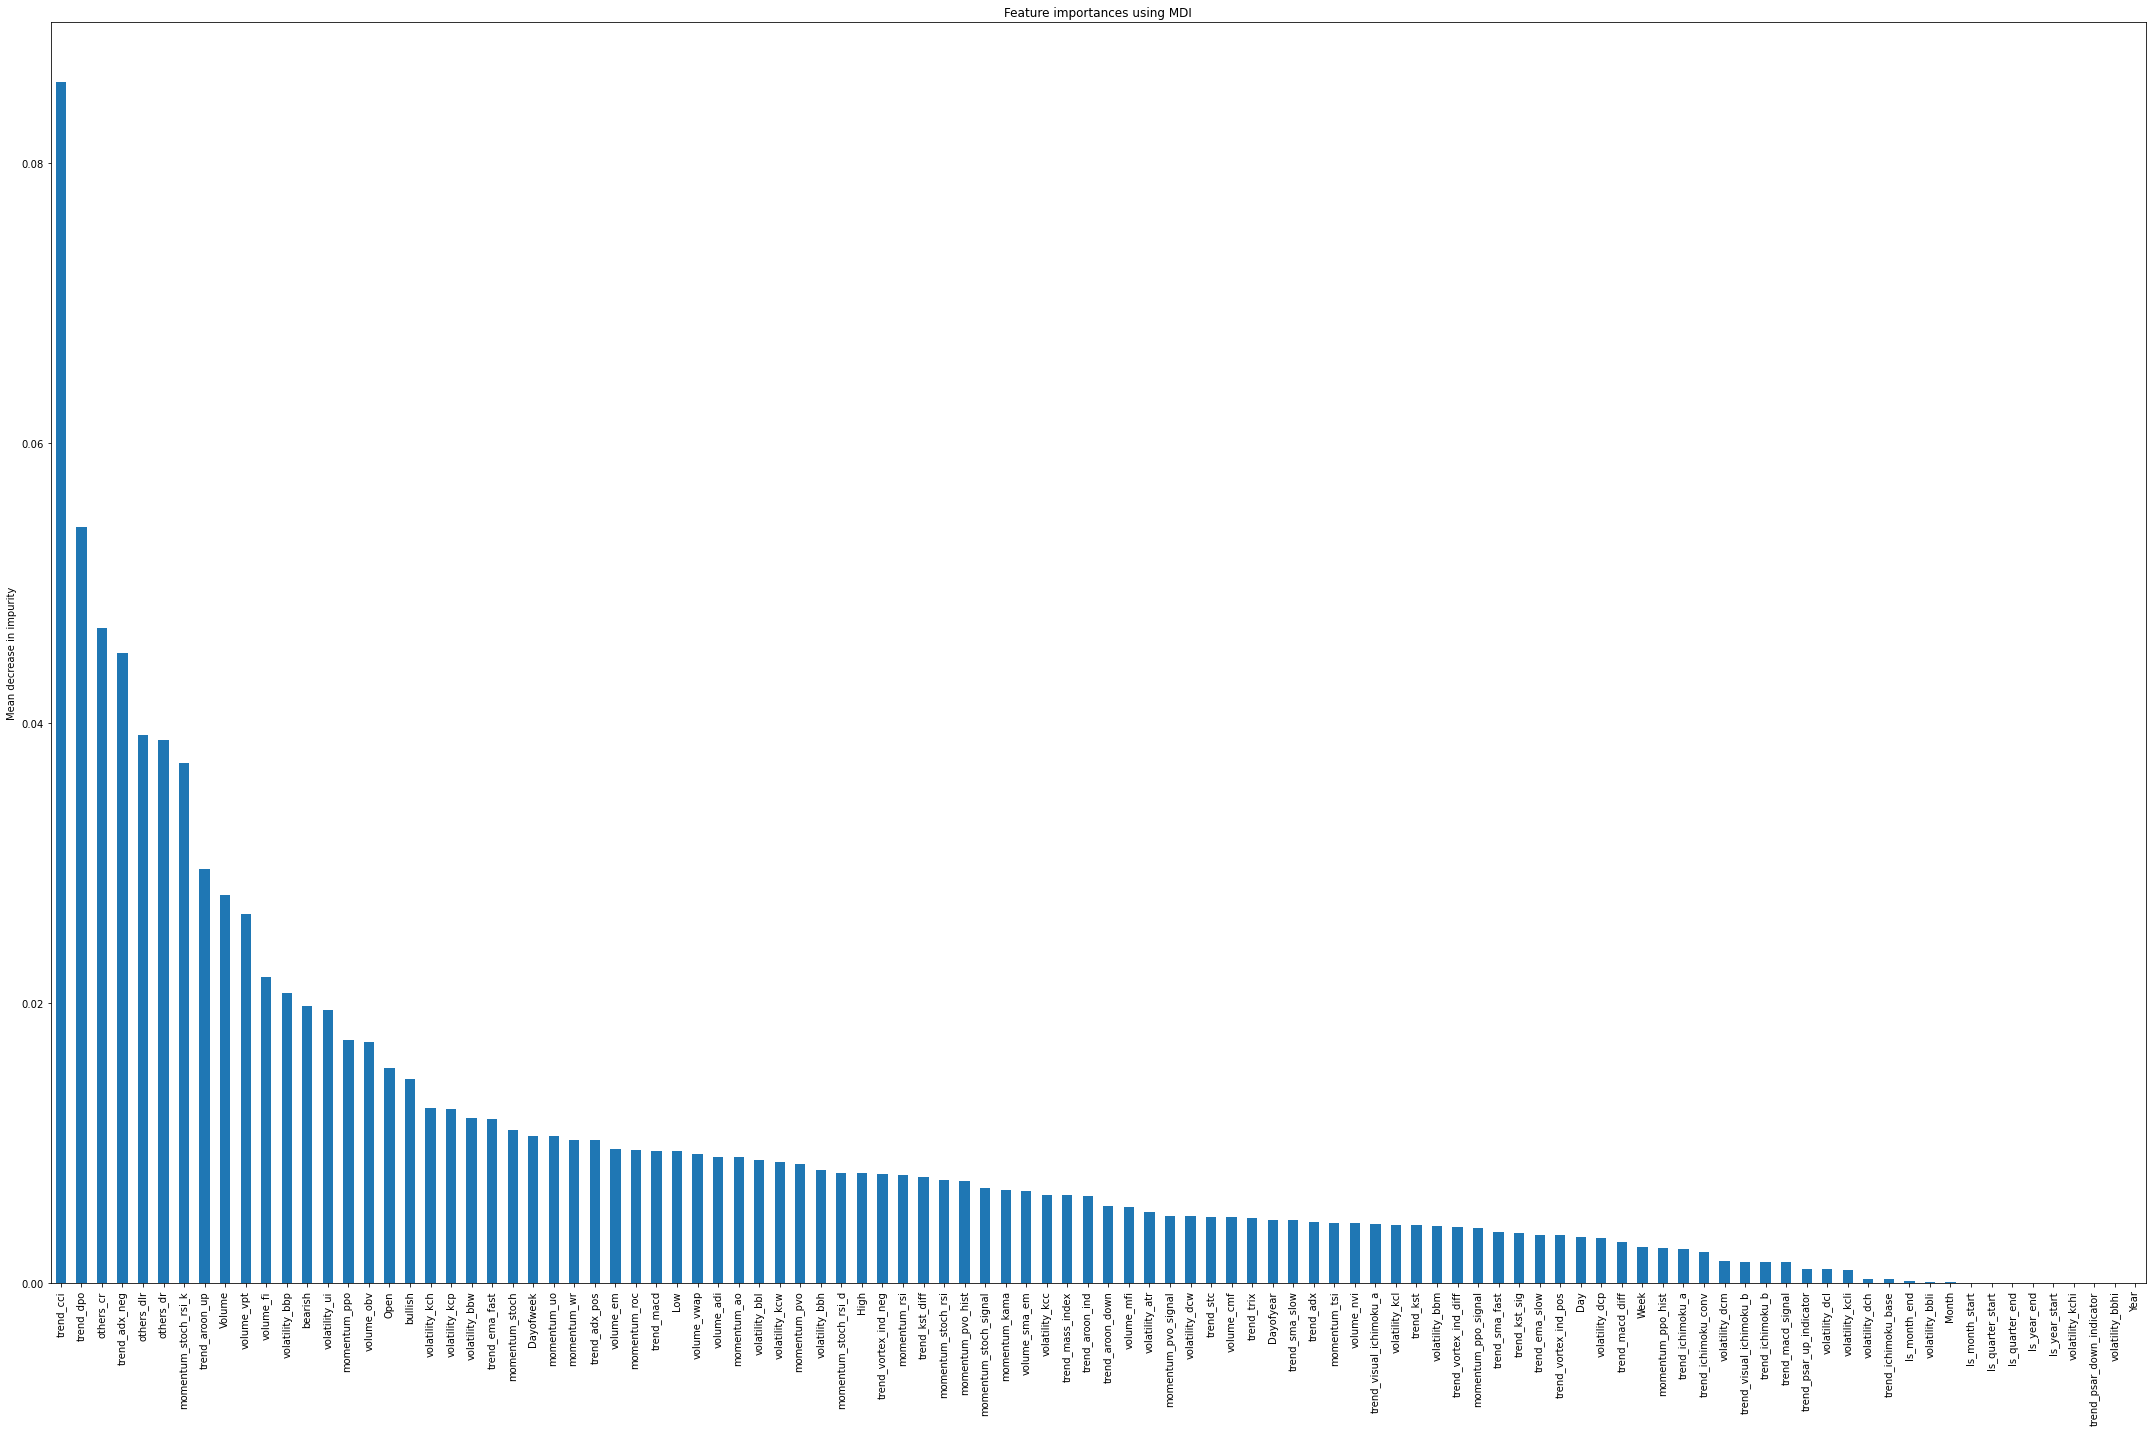

In [28]:
rf_MSFTs, ada_MSFTs, gra_MSFTs = sklearn_cross_validation(X_train_MSFTs, y_train_MSFTs, 5, verbose=True, plot=False)
ave_MSFTs = (rf_MSFTs + ada_MSFTs + gra_MSFTs) / 3
imp_MSFTs = feature_importance(ave_MSFTs, columns_MSFTs)

## Add NVDIA RoBERTa

In [29]:
# NVDA : Data with full set of technical features + sentiment score
X_train_NVDAs, y_train_NVDAs, columns_NVDAs = prepare_dataset(path = 'data/NVDA_data.csv', s_path = 'data/NVDA_byday_RoBERTa.csv', sentiment=True)

/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:938: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_up = pd.Series(index=self._psar.index)
/Users/ayakowatanabe/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:939: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self._psar_down = pd.Series(index=self._psar.index)


Mean Accuracy of Random Forests 0.6199999999999999
Mean Accuracy of Adaboost 0.5599999999999999
Mean Accuracy of Gradient Boosting 0.6199999999999999
Top 20 Best Features : 

volatility_bbh           0.098404
momentum_stoch_signal    0.055628
Dayofweek                0.038818
momentum_stoch_rsi_k     0.037197
bearish                  0.035793
bullish                  0.031834
volatility_atr           0.030717
trend_ichimoku_b         0.029110
trend_vortex_ind_diff    0.026812
volume_em                0.025226
others_dlr               0.023507
trend_vortex_ind_neg     0.023145
trend_dpo                0.022985
volume_vpt               0.022301
volume_mfi               0.022020
volume_cmf               0.021956
momentum_pvo             0.021107
others_dr                0.019165
momentum_roc             0.017178
momentum_ao              0.015889
dtype: float64


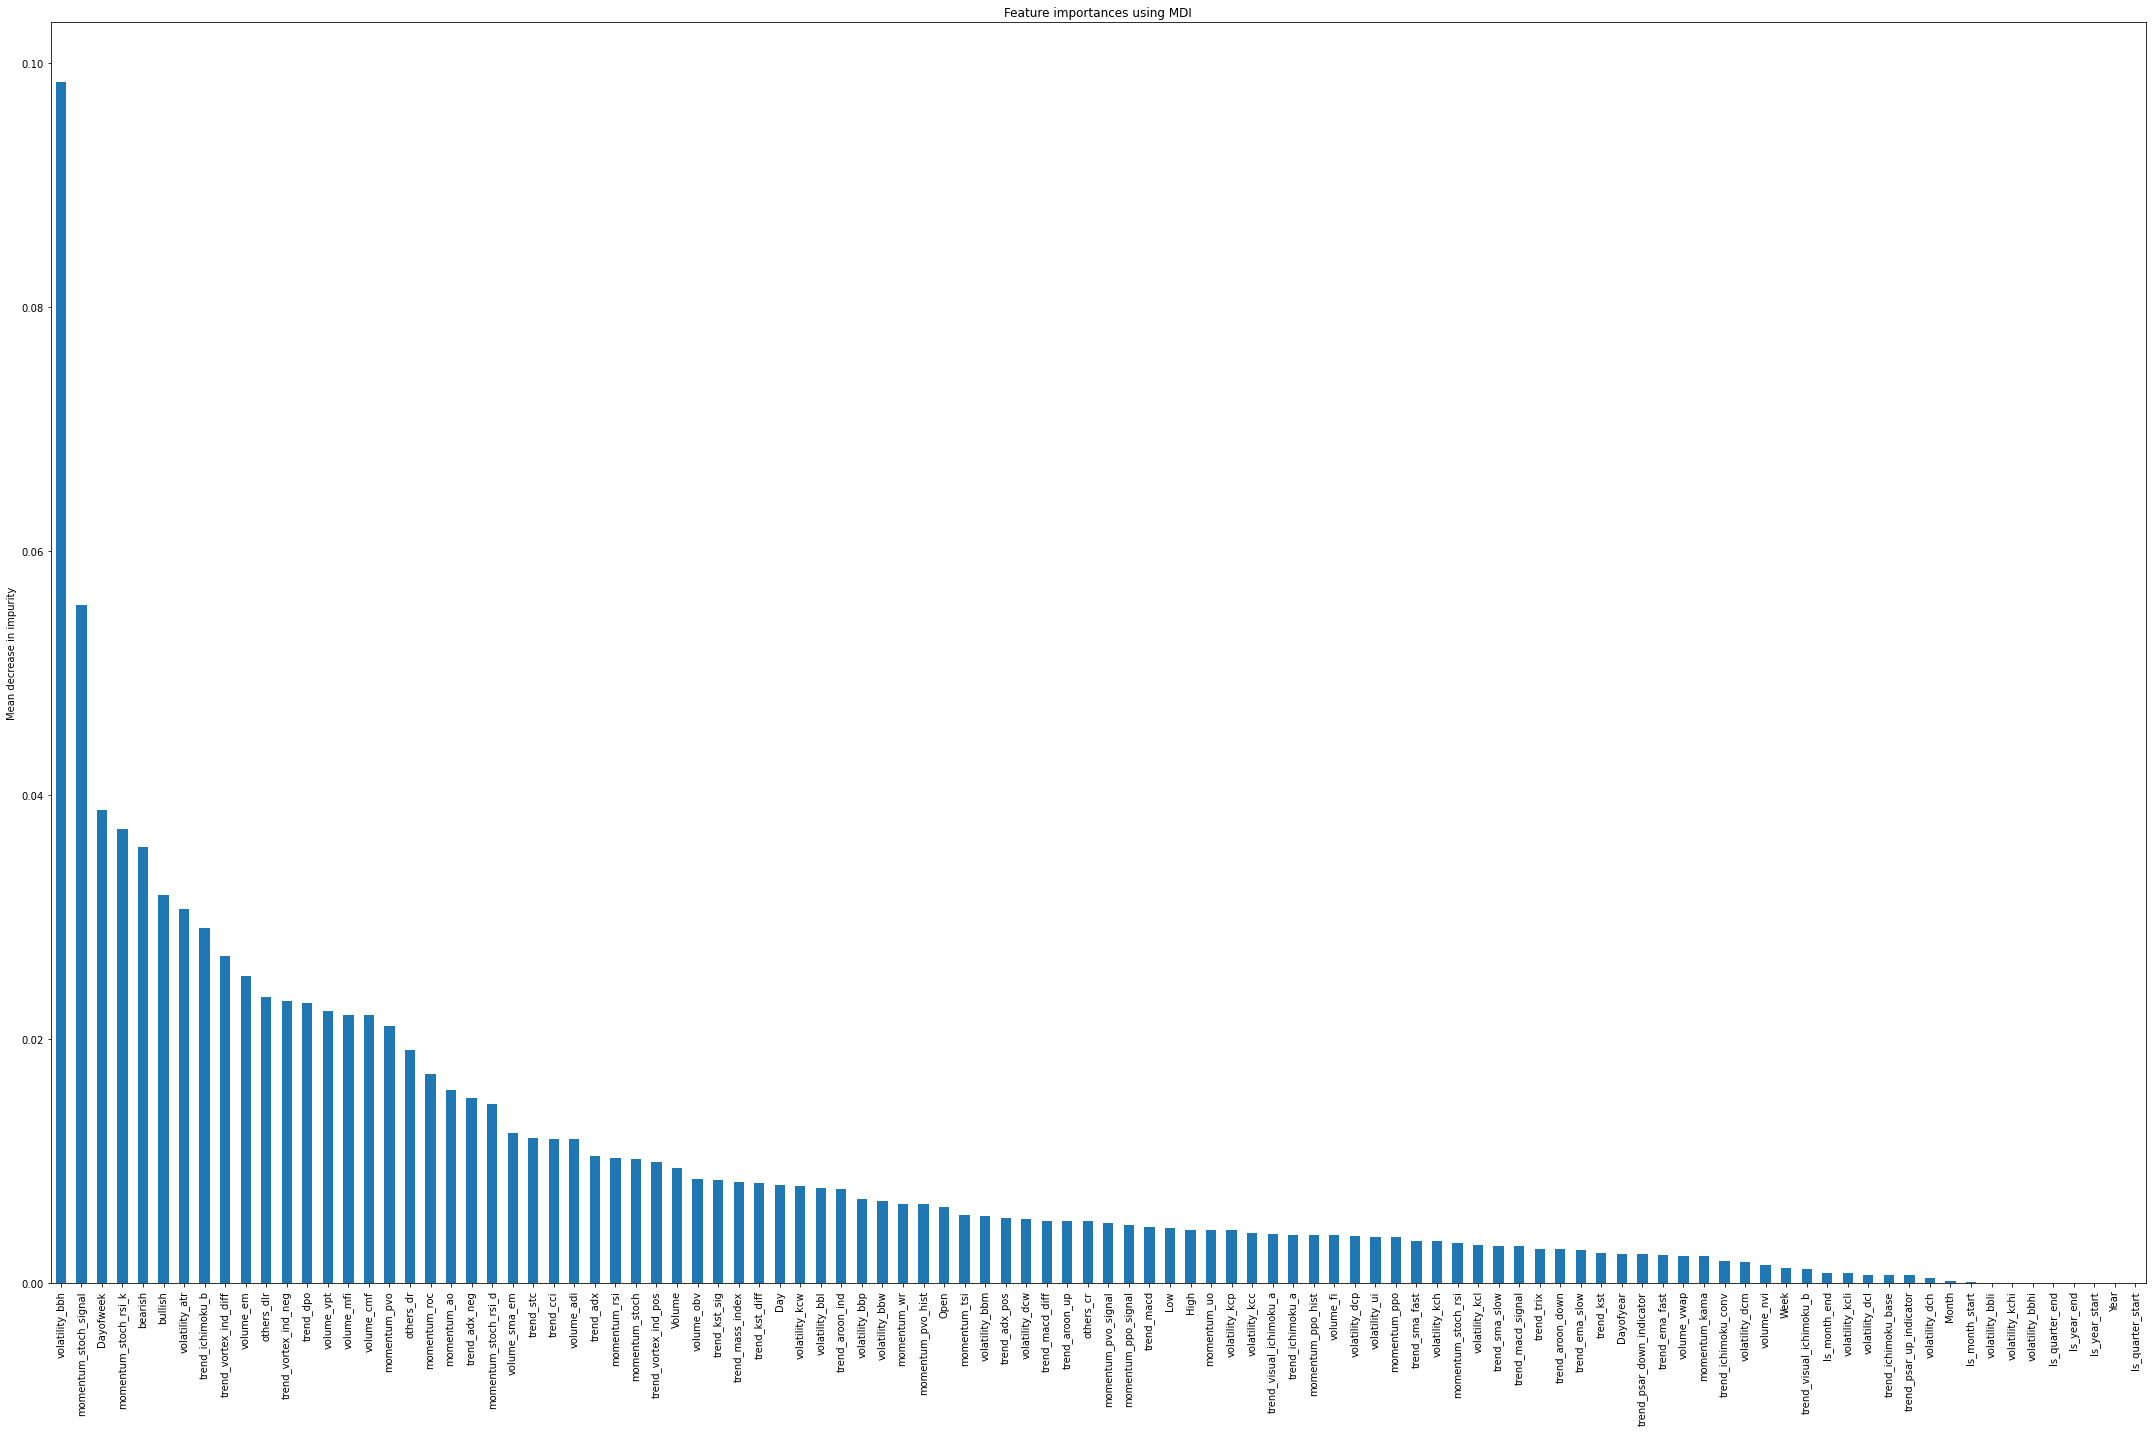

In [30]:
rf_NVDAs, ada_NVDAs, gra_NVDAs = sklearn_cross_validation(X_train_NVDAs, y_train_NVDAs, 5, verbose=True, plot=False)
ave_NVDAs = (rf_NVDAs + ada_NVDAs + gra_NVDAs) / 3
imp_NVDAs = feature_importance(ave_NVDAs, columns_NVDAs)

## Compare 3 companies feature importance with RoBERTa

In [31]:
imp_AAPLs.name = "AAPL"
imp_MSFTs.name = "MSFT"
imp_NVDAs.name = "NVDA"

all_companies_s = pd.merge(imp_AAPLs, imp_MSFTs, left_index=True, right_index=True)
all_companies_s = pd.merge(all_companies_s, imp_NVDAs, left_index=True, right_index=True)

<AxesSubplot:>

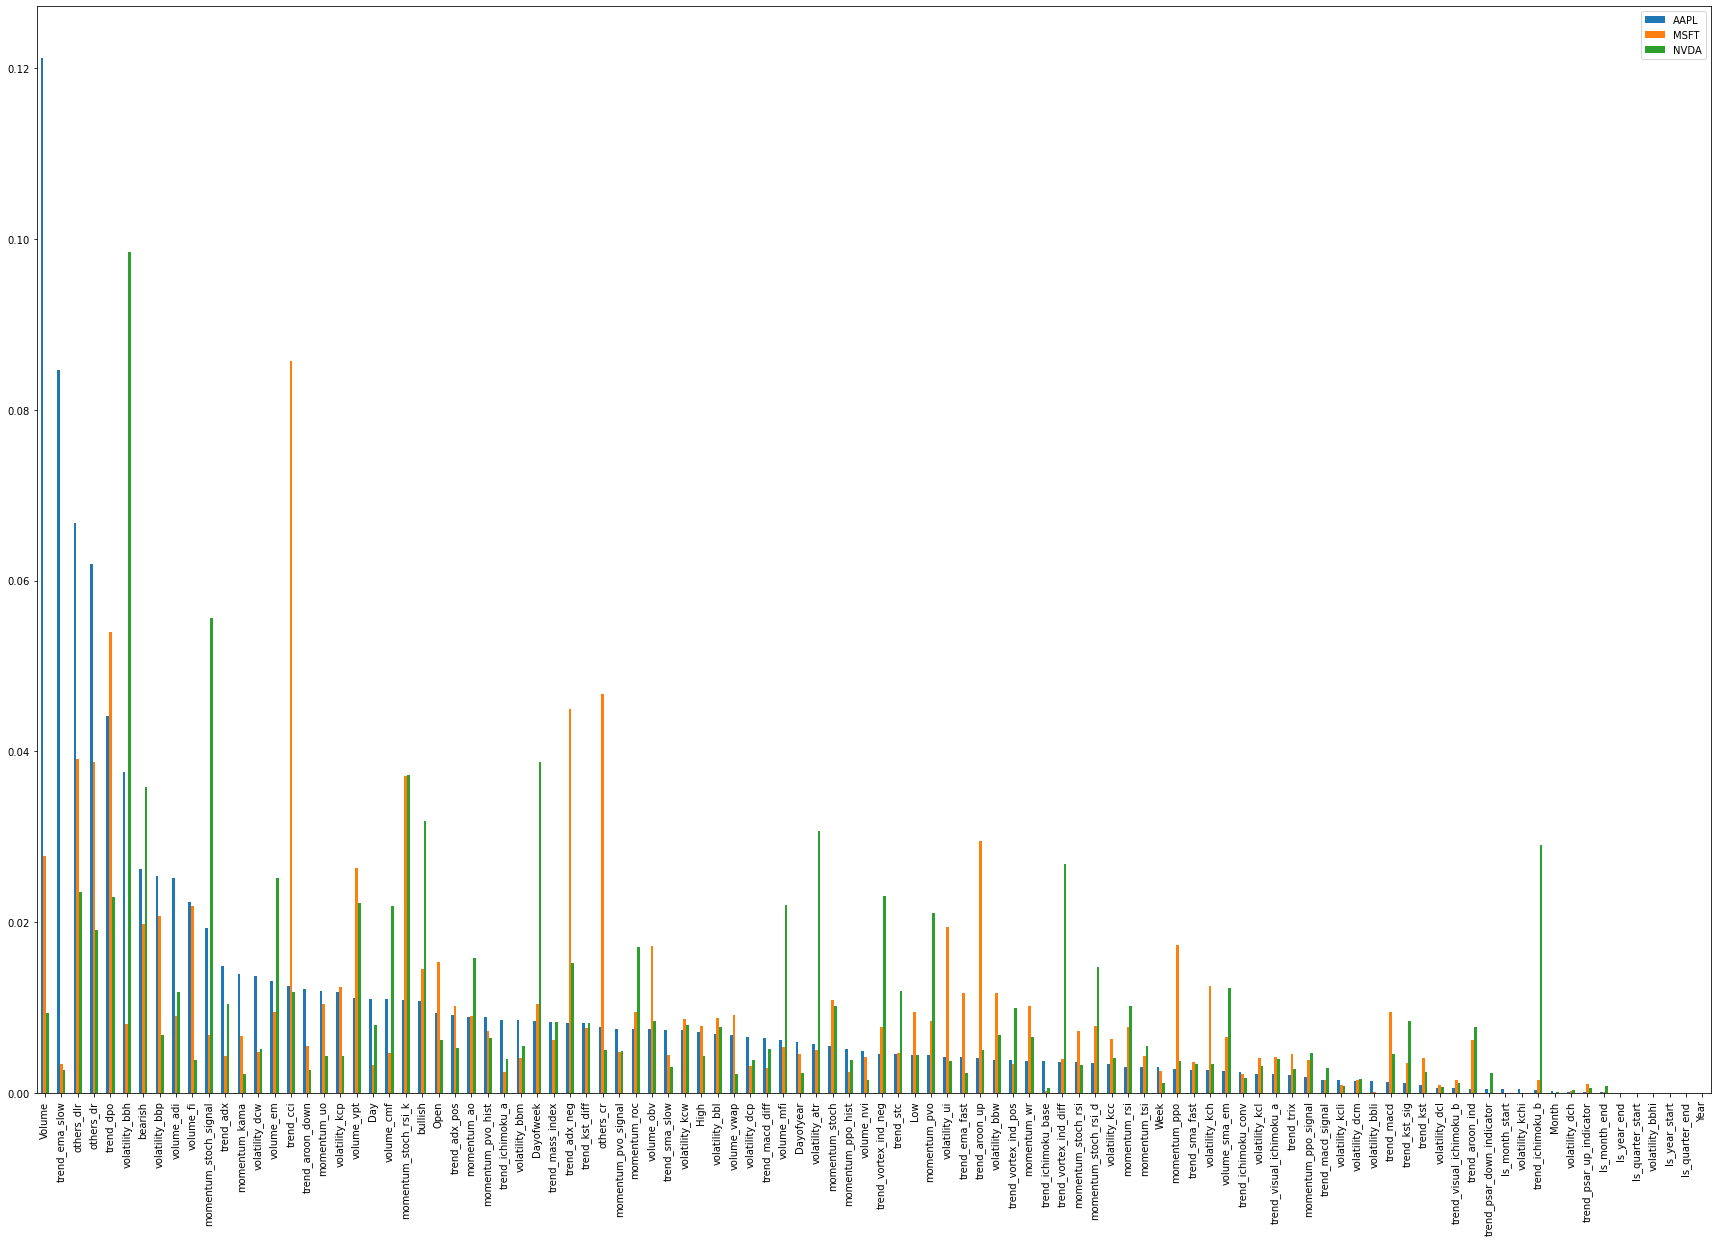

In [32]:
all_companies_s.plot(y=["AAPL", "MSFT", "NVDA"], kind="bar", figsize=(30,20), legend=True)

## Concatenate all three companies stocks and train the model

I concatenated by rows, but not sure this is the right way...

In [35]:
# Add index
X_train_AAPLss = np.insert(X_train_AAPLs, X_train_AAPLs.shape[1], values=[range(0, X_train_AAPLs.shape[0])], axis=1)
X_train_MSFTss = np.insert(X_train_MSFTs, X_train_MSFTs.shape[1], values=[range(0, X_train_MSFTs.shape[0])], axis=1)
X_train_NVDAss = np.insert(X_train_NVDAs, X_train_NVDAs.shape[1], values=[range(0, X_train_NVDAs.shape[0])], axis=1)
# Concatenate horizontally and order by index (time ascending)
X_train_alls = np.concatenate((X_train_AAPLss, X_train_MSFTss), axis=0)
X_train_alls = np.concatenate((X_train_alls, X_train_NVDAss), axis=0)
sort_order = X_train_alls[:,-1].argsort()
X_train_alls = X_train_alls[sort_order]
y_train_alls = np.concatenate((y_train_AAPLs, y_train_MSFTs), axis=0)
y_train_alls = np.concatenate((y_train_alls, y_train_NVDAs), axis=0)
y_train_alls = y_train_alls[sort_order]
X_train_alls = np.delete(X_train_alls, -1, axis=1)
# Make a dummy variable : AAPL=0, MSFT=1, NVDA=2
dummy1 = np.zeros(len(X_train_AAPLss))
dummy2 = np.ones(len(X_train_MSFTss))
dummy3 = np.full((len(X_train_NVDAss),), 2)
dummy = np.concatenate((dummy1, dummy2), axis=0)
dummy = np.concatenate((dummy, dummy3), axis=0)
dummy = dummy.reshape(-1,1)
dummy = dummy[sort_order]
X_train_alls = np.concatenate((X_train_alls, dummy), axis=1)
# Add column name
columns_alls = columns_AAPLs
columns_alls = columns_alls.to_list()
columns_alls.append("dummy")

Mean Accuracy of Random Forests 0.63125
Mean Accuracy of Adaboost 0.6
Mean Accuracy of Gradient Boosting 0.60625
Top 20 Best Features : 

momentum_stoch_rsi_k     0.097669
trend_cci                0.045137
trend_stc                0.044914
trend_dpo                0.038999
volume_vpt               0.032751
bearish                  0.031853
Day                      0.031745
Dayofweek                0.029367
trend_adx_neg            0.026258
momentum_stoch_signal    0.022730
momentum_uo              0.020053
Dayofyear                0.019457
momentum_roc             0.019043
volume_mfi               0.018479
Volume                   0.017827
volume_adi               0.017492
others_dr                0.017130
volume_em                0.015943
momentum_stoch_rsi_d     0.015569
volatility_bbh           0.015120
dtype: float64


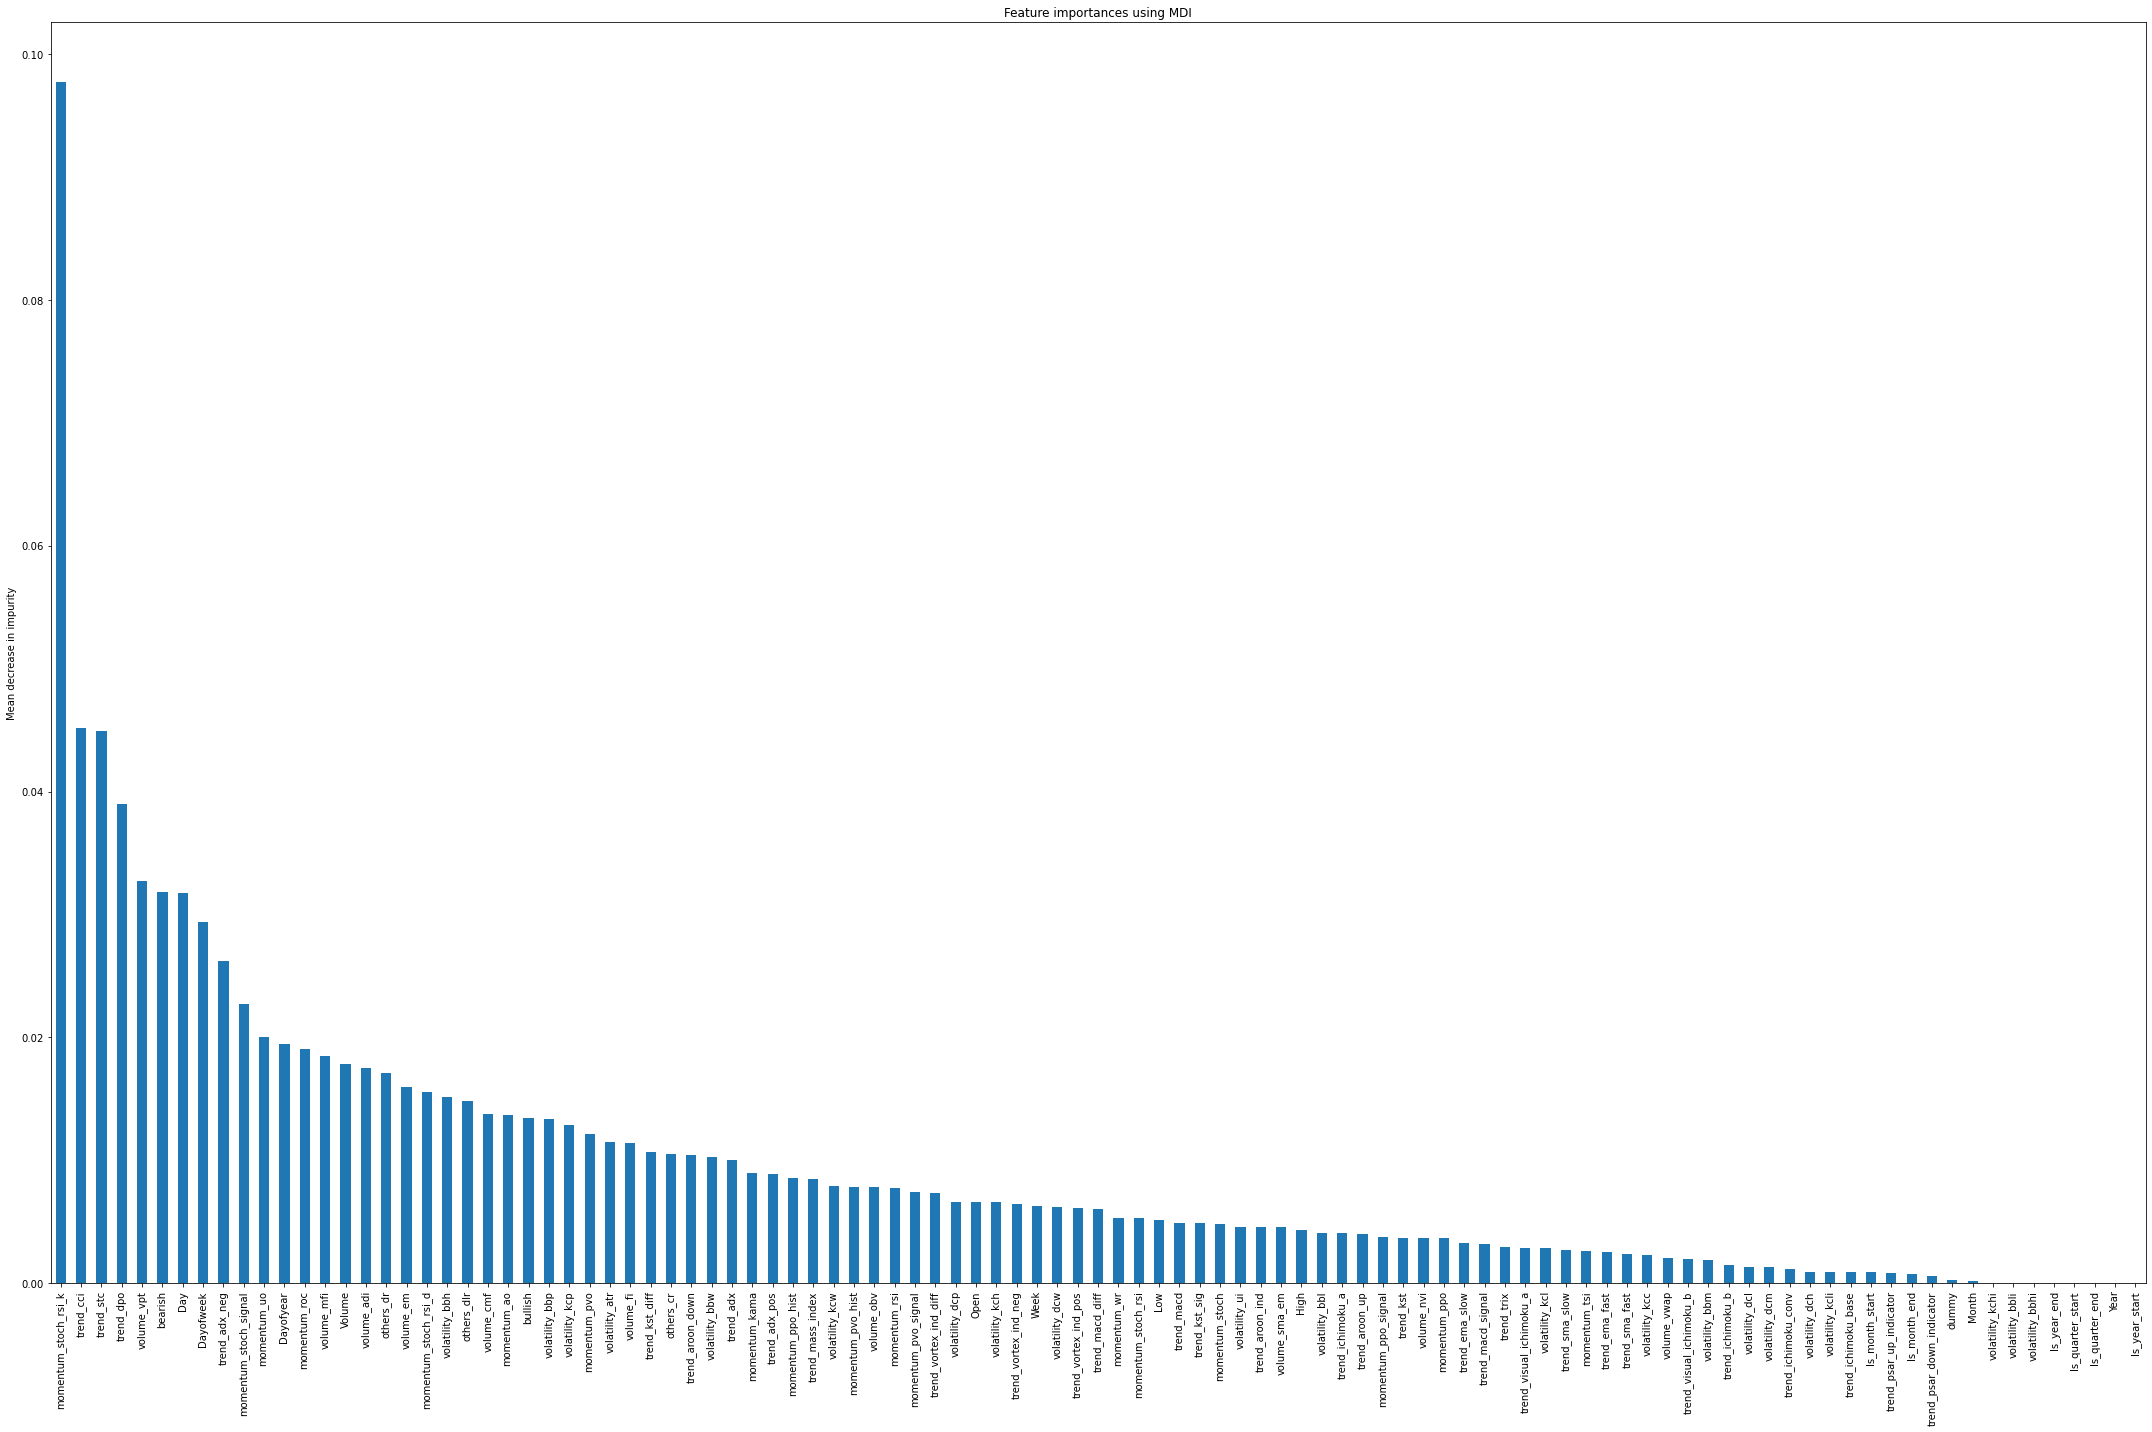

In [36]:
rf_alls, ada_alls, gra_alls = sklearn_cross_validation(X_train_alls, y_train_alls, 5, verbose=True, plot=False)
ave_alls = (rf_alls + ada_alls + gra_alls) / 3
imp_alls = feature_importance(ave_alls, columns_alls)